In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet

In [2]:
# transform_train for cifar10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# transform_test for cifar10
transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


# Load the CIFAR-10 training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-10 testing data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# hyperparameters
learning_rate = [0.01, 0.001, 0.1]
weight_decay = [0.0001, 0.001, 0.01]
device = torch.device("cuda")
criterion = nn.CrossEntropyLoss()

In [ ]:
batch_s = 2048
training_accuracy_list_all = []
testing_accuracy_list_all = []
training_loss_list_all = []
testing_loss_list_all = []
# Create data loaders
num_epochs = 300   # don't make it a variable first
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_s, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_s, shuffle=False, num_workers=8)
for learning_r in learning_rate:
    for weight_d in weight_decay:
        model = models.efficientnet_b0(num_classes=10).to(device)
        optimiser = optim.Adam(model.parameters(), lr=learning_r, weight_decay = weight_d)
        title_1 = f"Accuracy experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        title_2 = f"Loss experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        epoch_list = []
        training_accuracy_list = []
        testing_accuracy_list = []
        training_loss_list = []
        testing_loss_list = []
        for epoch in range(num_epochs):
            training_loss = 0.0
            training_correct = 0
            training_total = 0
            num_batches_training = len(trainloader)
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                training_total += labels.size(0)
                training_correct += (predicted == labels).sum().item()
                training_loss += loss.item()
            average_training_loss = training_loss/num_batches_training
            print(f"{epoch + 1} average training loss: {average_training_loss:.3f}")
            print(f"Training Accuracy of the network on the 50000 train images: {100 * training_correct / training_total}%")
            epoch_list.append(epoch+1)
            training_accuracy_list.append(100 * training_correct / training_total)
            training_loss_list.append(average_training_loss)
            
            # Step 6: Evaluate the model
            with torch.no_grad():
                val_loss = 0
                number_batches = len(testloader)
                correct = 0
                total = 0
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    batch_loss = criterion(outputs, labels)
                    val_loss += batch_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                val_loss /= number_batches
                print("val_loss:", val_loss)
                print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
                testing_accuracy_list.append(100 * correct / total)
                testing_loss_list.append(val_loss)
        training_accuracy_list_all.append(training_accuracy_list)
        testing_accuracy_list_all.append(testing_accuracy_list)
        training_loss_list_all.append(training_loss_list)
        testing_loss_list_all.append(testing_loss_list)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_accuracy_list, label='Training Accuracy')
        plt.plot(epoch_list, testing_accuracy_list, label='Testing Accuracy')
        plt.title(title_1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.savefig(f"./{title_1}_cifar100.png", dpi=300)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_loss_list, label='Training Loss')
        plt.plot(epoch_list, testing_loss_list, label='Testing Loss')
        plt.title(title_2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"./{title_2}_cifar100.png", dpi=300)
                


1 average training loss: 4.960
Training Accuracy of the network on the 50000 train images: 1.5%
val_loss: 4.954308891296387
Accuracy of the network on the 10000 test images: 2.0%
2 average training loss: 4.722
Training Accuracy of the network on the 50000 train images: 1.836%
val_loss: 4.787136840820312
Accuracy of the network on the 10000 test images: 2.14%
3 average training loss: 4.770
Training Accuracy of the network on the 50000 train images: 1.94%
val_loss: 4.633199691772461
Accuracy of the network on the 10000 test images: 1.93%
4 average training loss: 4.538
Training Accuracy of the network on the 50000 train images: 2.372%
val_loss: 4.51273365020752
Accuracy of the network on the 10000 test images: 3.18%
5 average training loss: 4.425
Training Accuracy of the network on the 50000 train images: 3.246%
val_loss: 4.433881092071533
Accuracy of the network on the 10000 test images: 3.95%
6 average training loss: 4.299
Training Accuracy of the network on the 50000 train images: 4.18

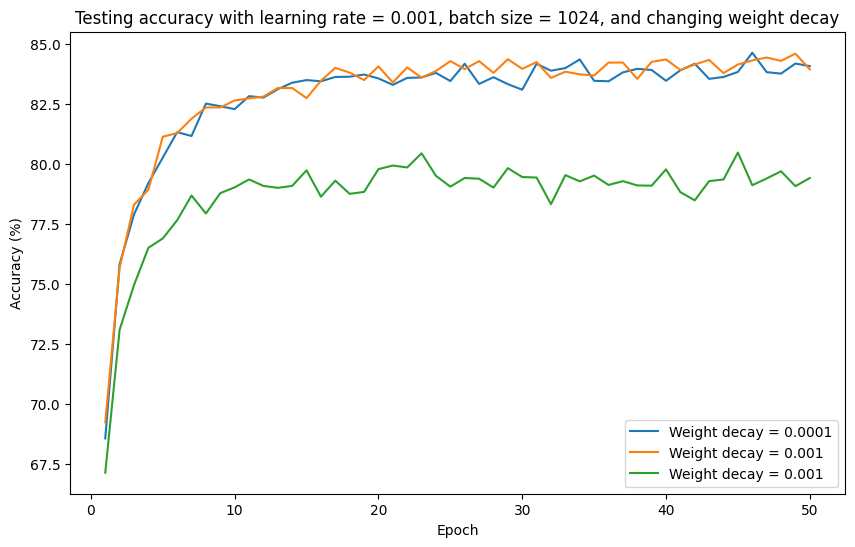

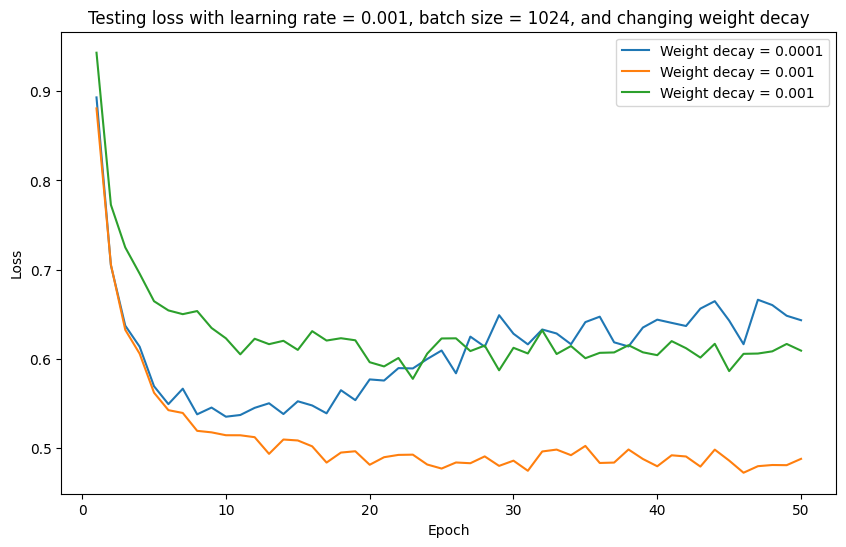

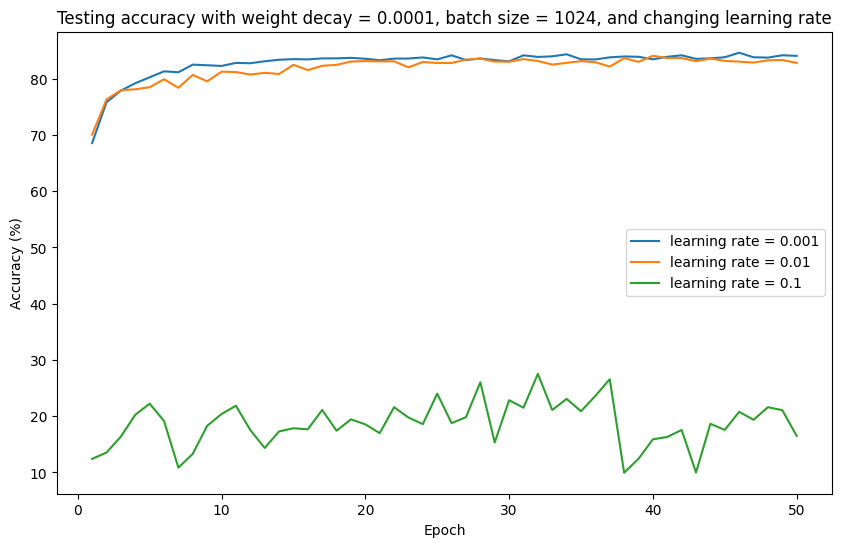

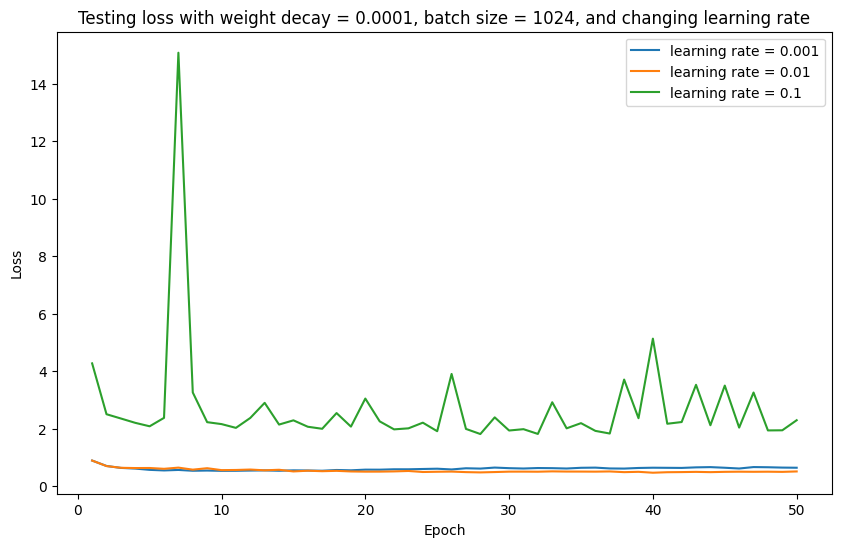

In [5]:
np_testing_accuracy_list_all = np.array(testing_accuracy_list_all)
np.save("./testing_accuries.npy", np_testing_accuracy_list_all)
np_testing_loss_list_all = np.array(testing_loss_list_all)
np.save("./testing_losses.npy", np_testing_loss_list_all)


np_training_accuracy_list_all = np.array(training_accuracy_list_all)
np.save("./training_accuries.npy", np_training_accuracy_list_all)
np_training_loss_list_all = np.array(training_loss_list_all)
np.save("./training_losses.npy", np_training_loss_list_all)

epoch_list = np.arange(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all[0], label='Weight decay = 0.0001')
plt.plot(epoch_list, testing_accuracy_list_all[1], label='Weight decay = 0.001')
plt.plot(epoch_list, testing_accuracy_list_all[2], label='Weight decay = 0.001')
title = "Testing accuracy with learning rate = 0.001, batch size = 1024, and changing weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all[0], label='Weight decay = 0.0001')
plt.plot(epoch_list, testing_loss_list_all[1], label='Weight decay = 0.001')
plt.plot(epoch_list, testing_loss_list_all[2], label='Weight decay = 0.001')
title = "Testing loss with learning rate = 0.001, batch size = 1024, and changing weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all[0], label='learning rate = 0.001')
plt.plot(epoch_list, testing_accuracy_list_all[3], label='learning rate = 0.01')
plt.plot(epoch_list, testing_accuracy_list_all[6], label='learning rate = 0.1')
title = "Testing accuracy with weight decay = 0.0001, batch size = 1024, and changing learning rate"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all[0], label='learning rate = 0.001')
plt.plot(epoch_list, testing_loss_list_all[3], label='learning rate = 0.01')
plt.plot(epoch_list, testing_loss_list_all[6], label='learning rate = 0.1')
title = "Testing loss with weight decay = 0.0001, batch size = 1024, and changing learning rate"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)

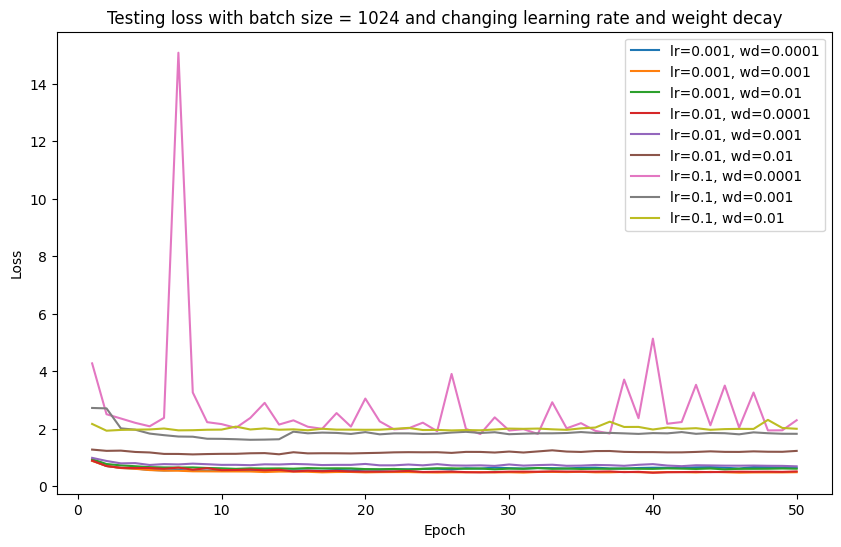

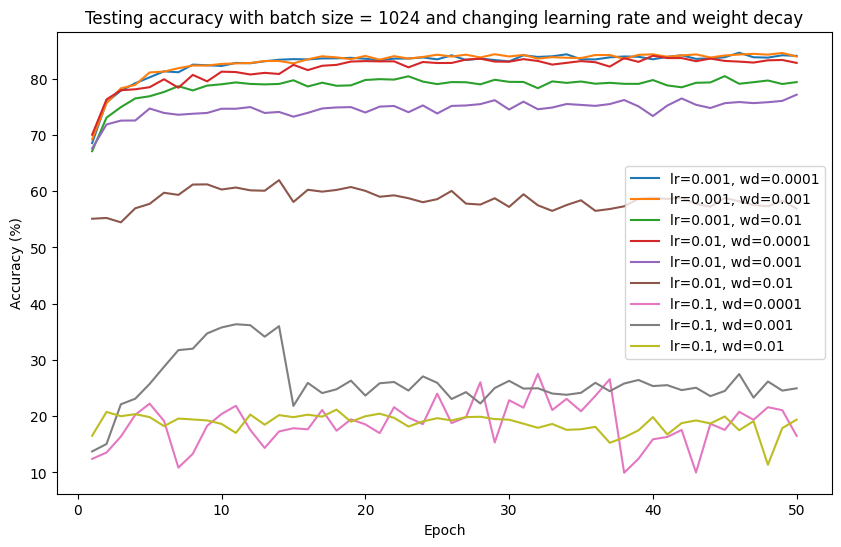

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all[8], label='lr=0.1, wd=0.01')

title = "Testing loss with batch size = 1024 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all[8], label='lr=0.1, wd=0.01')

title = "Testing accuracy with batch size = 1024 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)

Loaded pretrained weights for efficientnet-b0
1 average training loss: 1.169
Training Accuracy of the network on the 50000 train images: 58.822%
val_loss: 0.818676671385765
Accuracy of the network on the 10000 test images: 71.29%
2 average training loss: 0.700
Training Accuracy of the network on the 50000 train images: 75.41%
val_loss: 0.6731182157993316
Accuracy of the network on the 10000 test images: 76.9%
3 average training loss: 0.581
Training Accuracy of the network on the 50000 train images: 79.604%
val_loss: 0.6009717077016831
Accuracy of the network on the 10000 test images: 79.63%
4 average training loss: 0.510
Training Accuracy of the network on the 50000 train images: 82.048%
val_loss: 0.5810981869697571
Accuracy of the network on the 10000 test images: 80.46%
5 average training loss: 0.461
Training Accuracy of the network on the 50000 train images: 83.702%
val_loss: 0.5475319027900696
Accuracy of the network on the 10000 test images: 81.63%
6 average training loss: 0.423
T

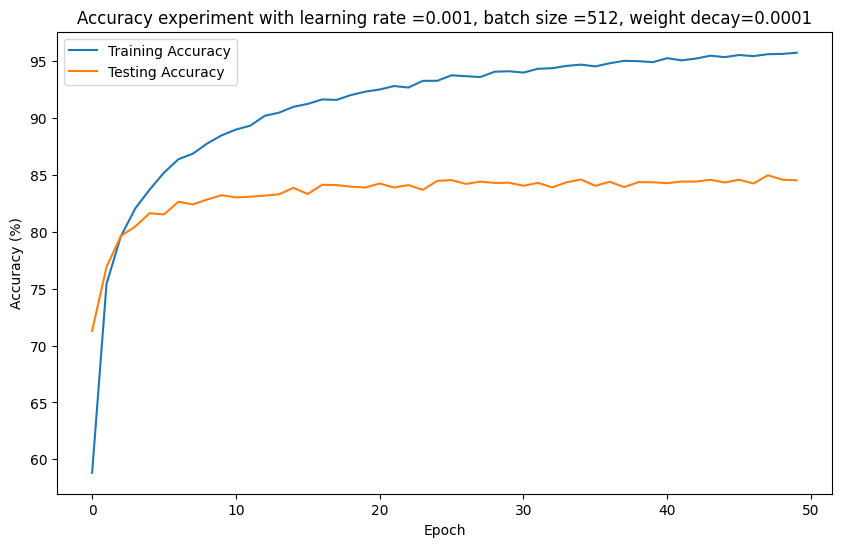

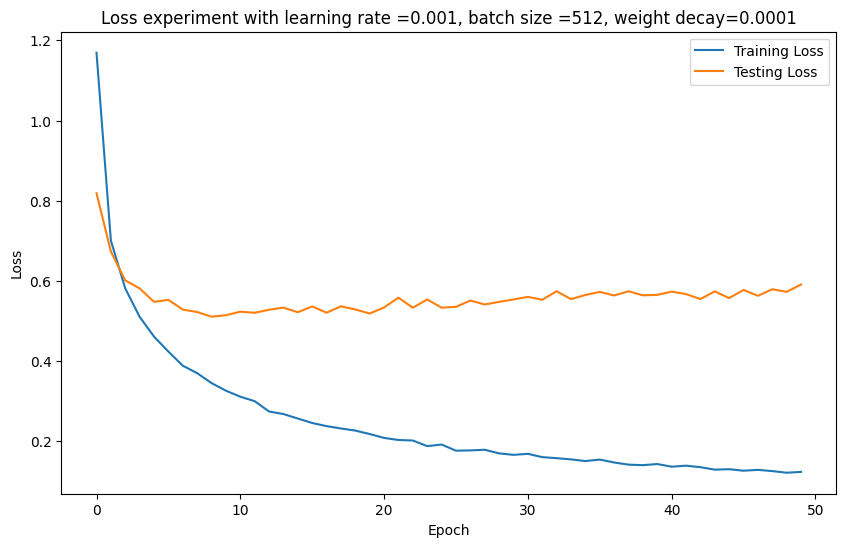

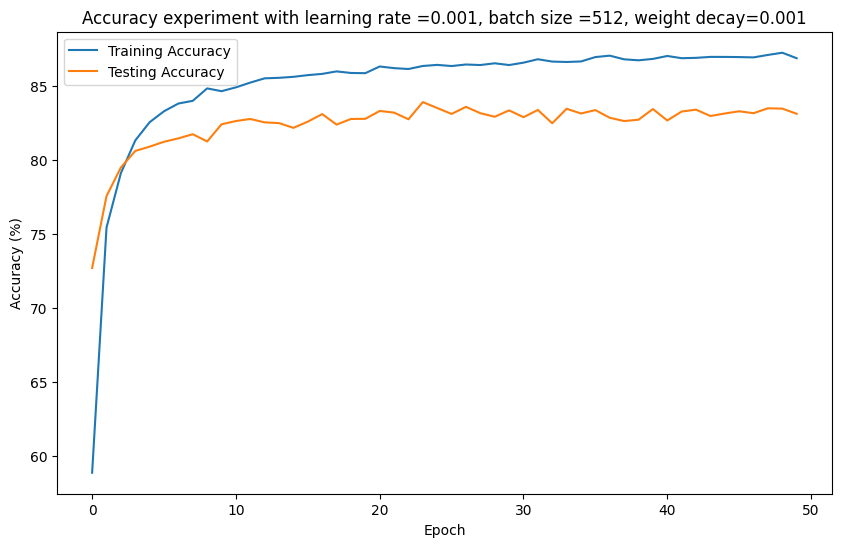

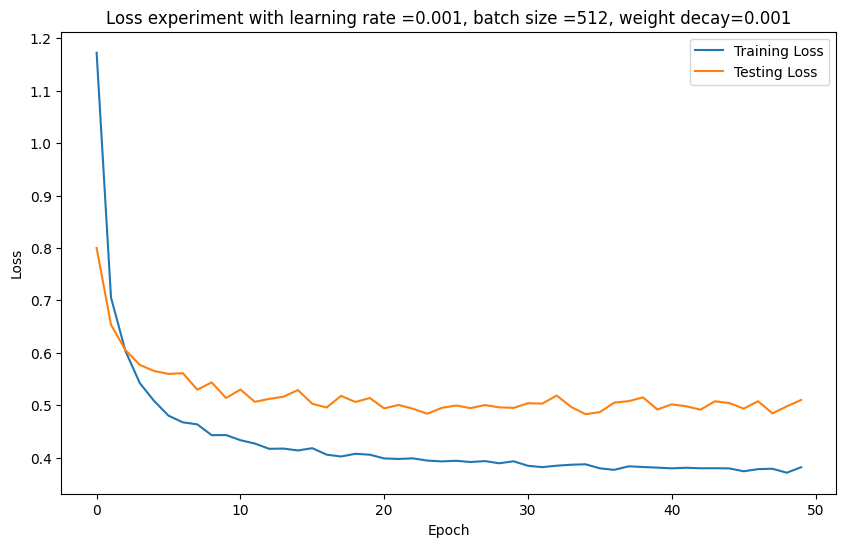

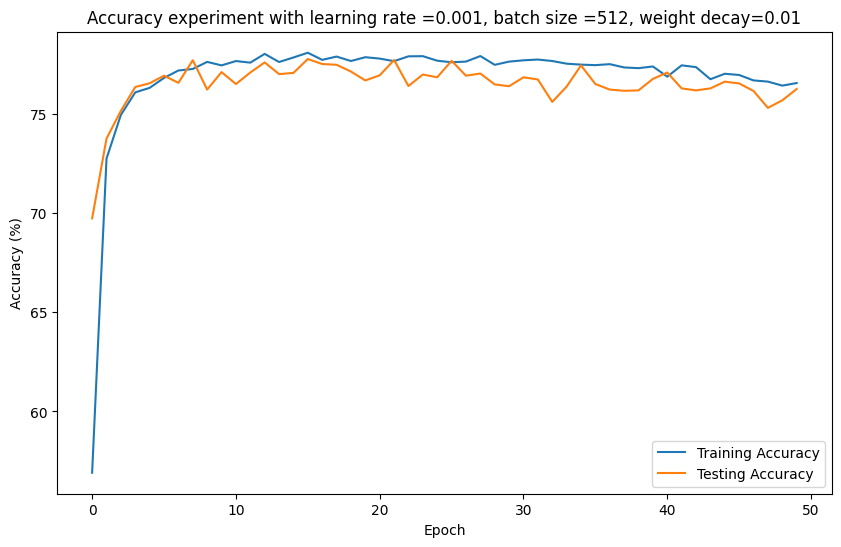

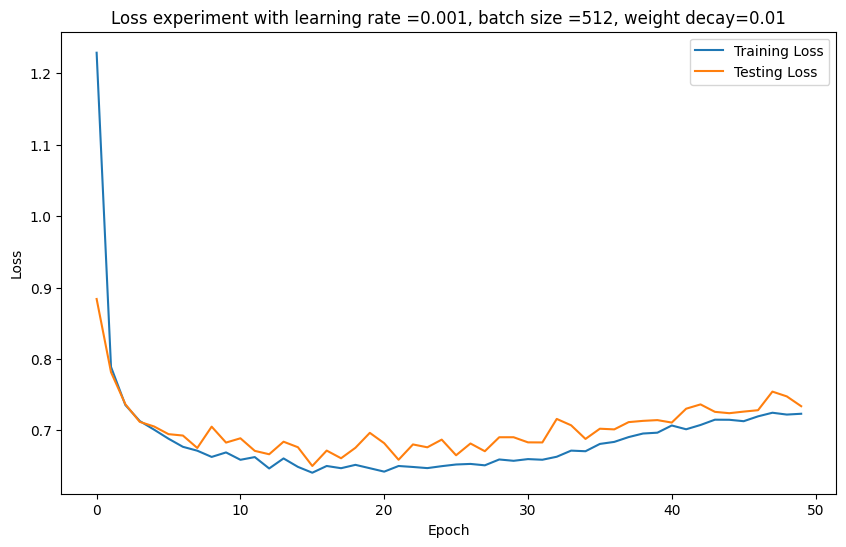

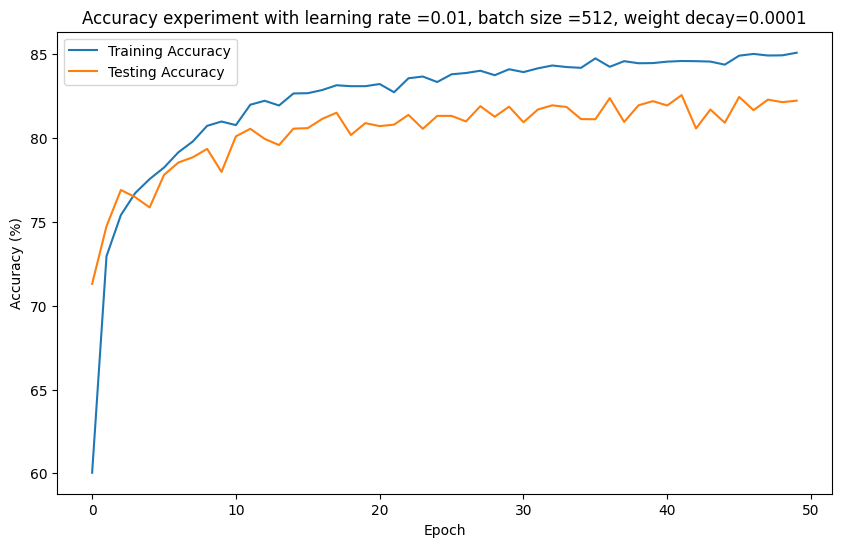

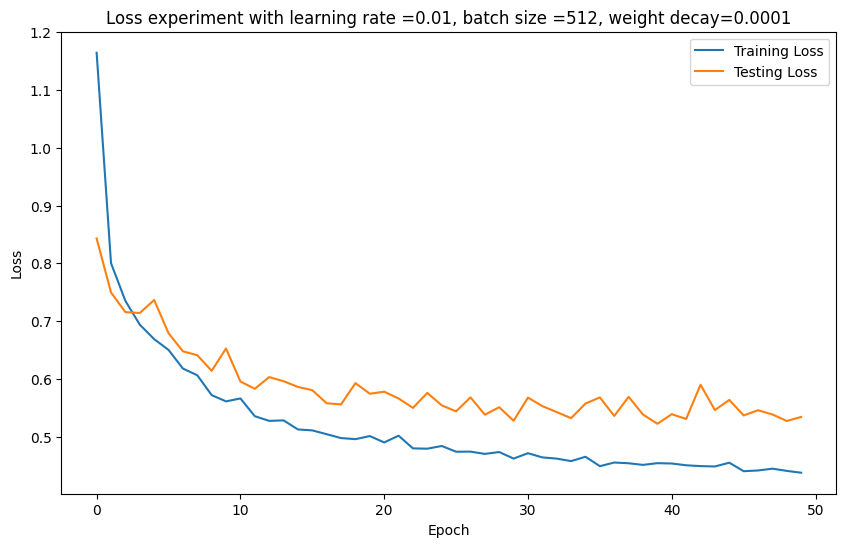

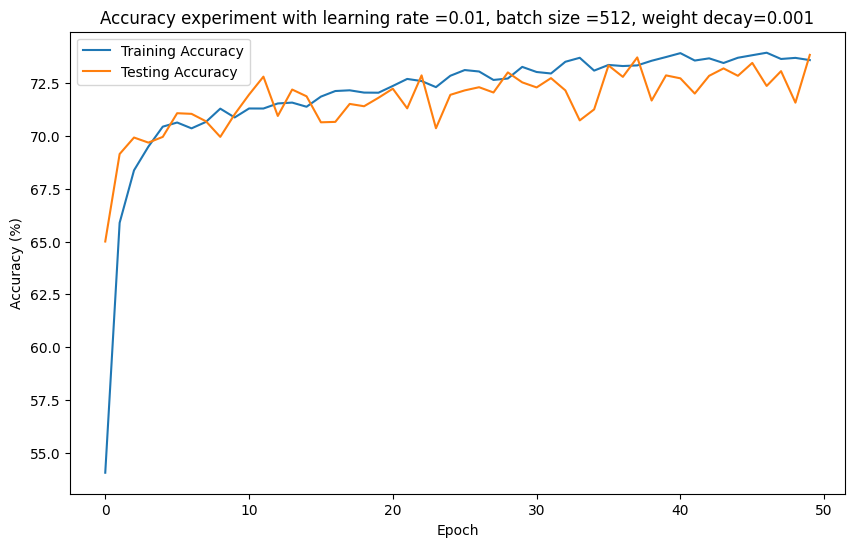

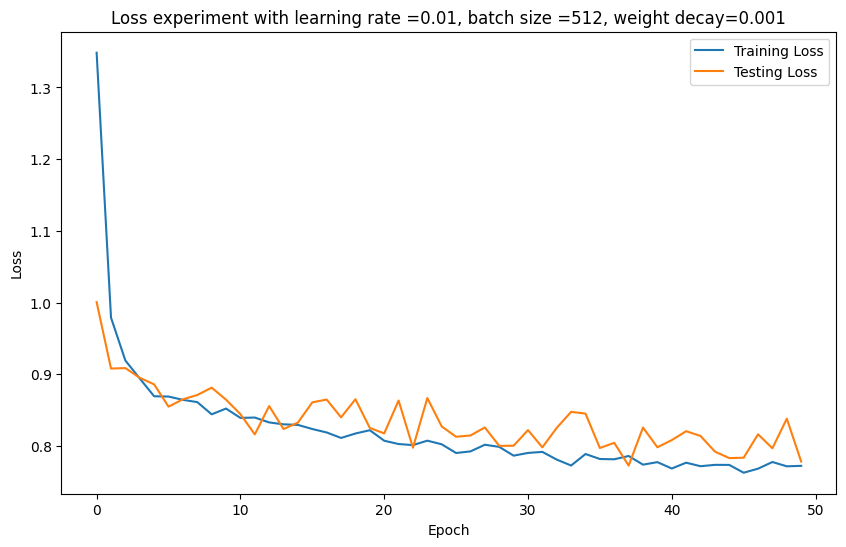

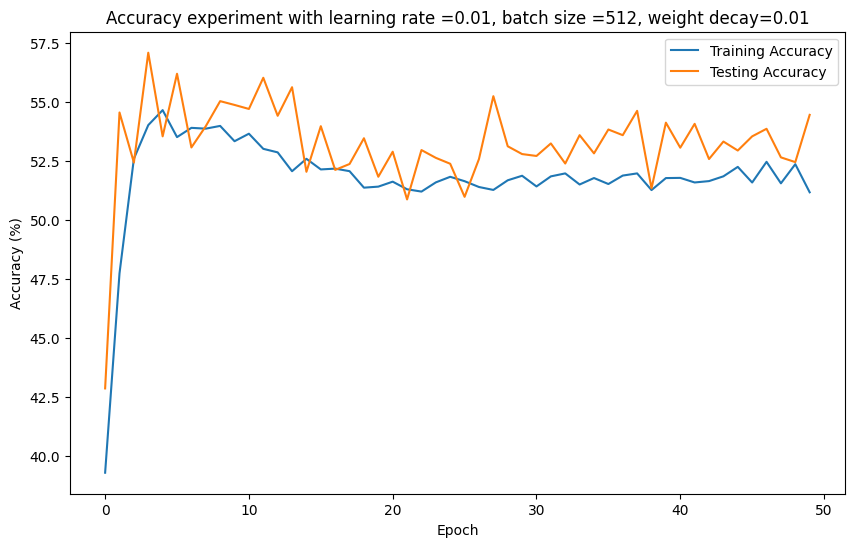

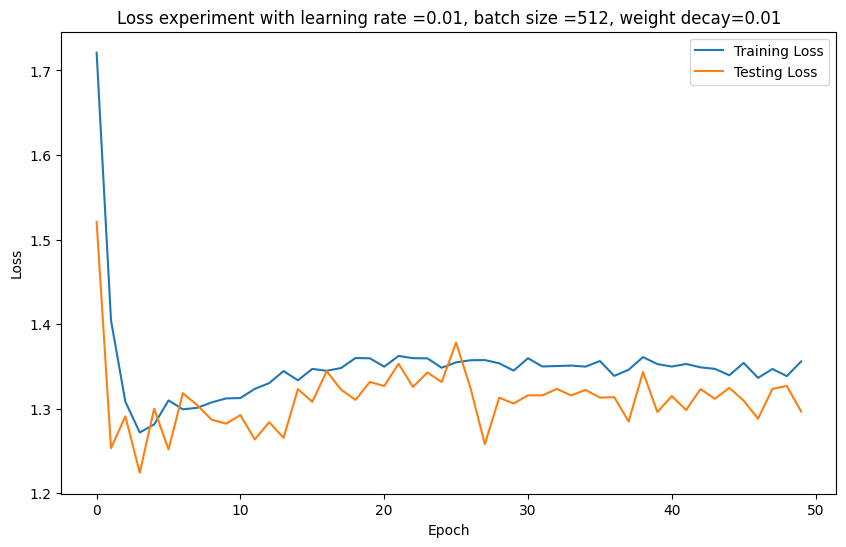

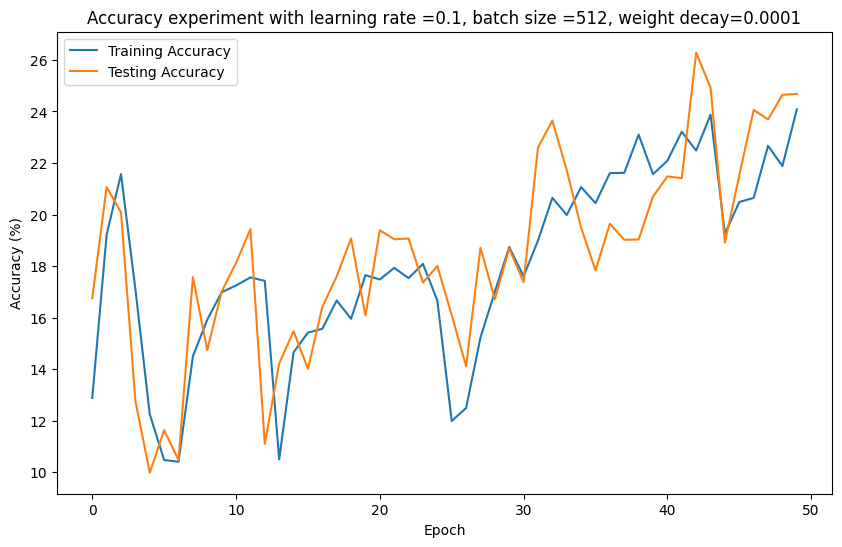

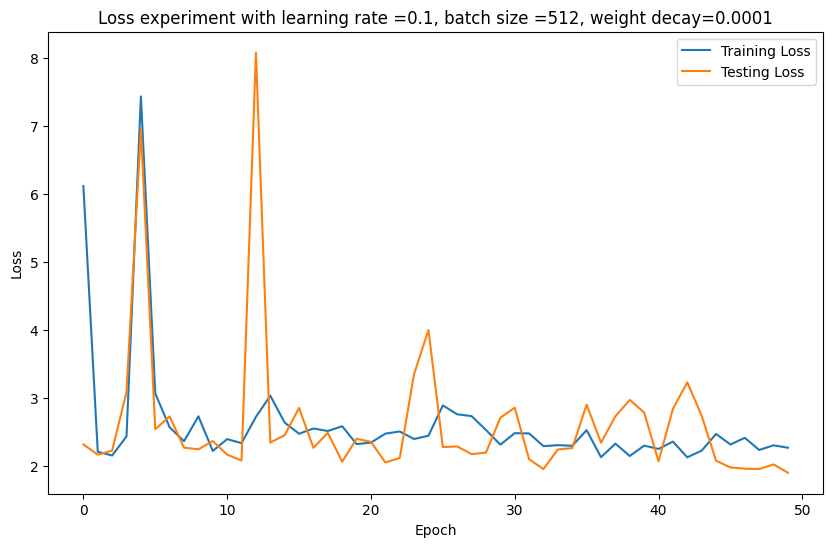

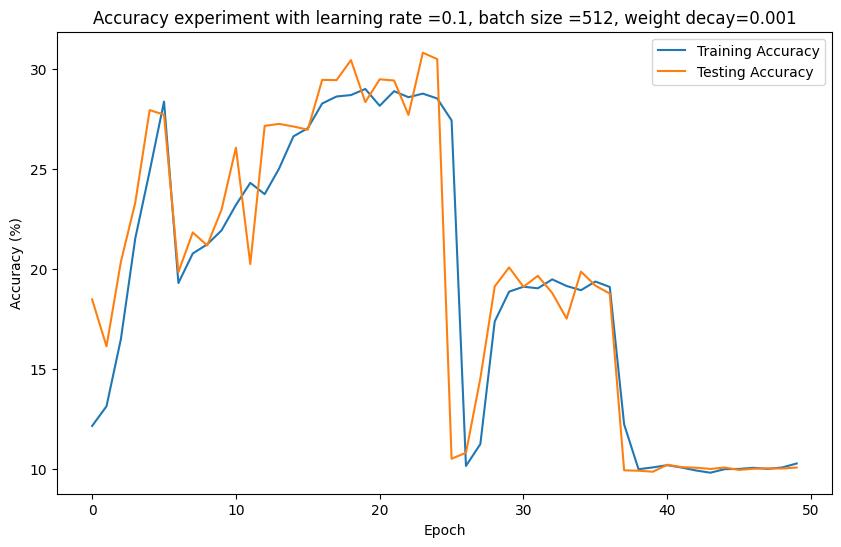

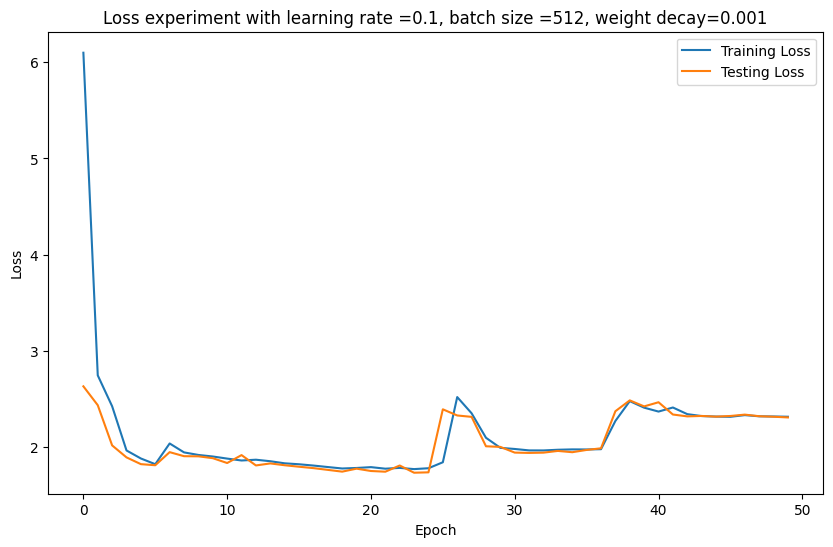

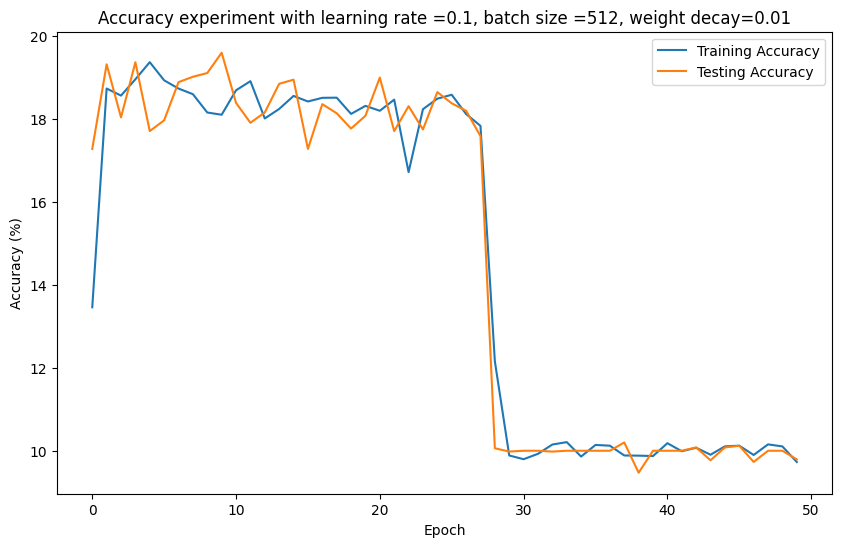

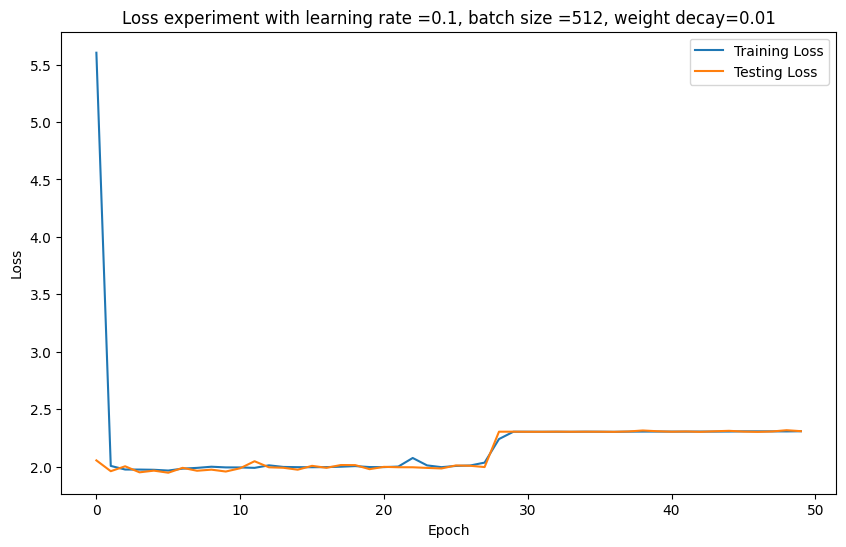

In [7]:
batch_s = 512
training_accuracy_list_all_512 = []
testing_accuracy_list_all_512 = []
training_loss_list_all_512 = []
testing_loss_list_all_512 = []
# Create data loaders
num_epochs = 50   # don't make it a variable first
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_s, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_s, shuffle=False, num_workers=8)
for learning_r in learning_rate:
    for weight_d in weight_decay:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10).to(device)
        optimiser = optim.Adam(model.parameters(), lr=learning_r, weight_decay = weight_d)
        title_1 = f"Accuracy experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        title_2 = f"Loss experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        epoch_list = []
        training_accuracy_list = []
        testing_accuracy_list = []
        training_loss_list = []
        testing_loss_list = []
        for epoch in range(num_epochs):
            training_loss = 0.0
            training_correct = 0
            training_total = 0
            num_batches_training = len(trainloader)
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                training_total += labels.size(0)
                training_correct += (predicted == labels).sum().item()
                training_loss += loss.item()
            average_training_loss = training_loss/num_batches_training
            print(f"{epoch + 1} average training loss: {average_training_loss:.3f}")
            print(f"Training Accuracy of the network on the 50000 train images: {100 * training_correct / training_total}%")
            epoch_list.append(epoch)
            training_accuracy_list.append(100 * training_correct / training_total)
            training_loss_list.append(average_training_loss)
            
            # Step 6: Evaluate the model
            with torch.no_grad():
                val_loss = 0
                number_batches = len(testloader)
                correct = 0
                total = 0
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    batch_loss = criterion(outputs, labels)
                    val_loss += batch_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                val_loss /= number_batches
                print("val_loss:", val_loss)
                # Reduce learning rate when validation loss plateaus
                # scheduler.step(val_loss)
                print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
                testing_accuracy_list.append(100 * correct / total)
                testing_loss_list.append(val_loss)
        training_accuracy_list_all_512.append(training_accuracy_list)
        testing_accuracy_list_all_512.append(testing_accuracy_list)
        training_loss_list_all_512.append(training_loss_list)
        testing_loss_list_all_512.append(testing_loss_list)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_accuracy_list, label='Training Accuracy')
        plt.plot(epoch_list, testing_accuracy_list, label='Testing Accuracy')
        plt.title(title_1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.savefig(f"./{title_1}.png", dpi=300)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_loss_list, label='Training Loss')
        plt.plot(epoch_list, testing_loss_list, label='Testing Loss')
        plt.title(title_2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"./{title_2}.png", dpi=300)
                


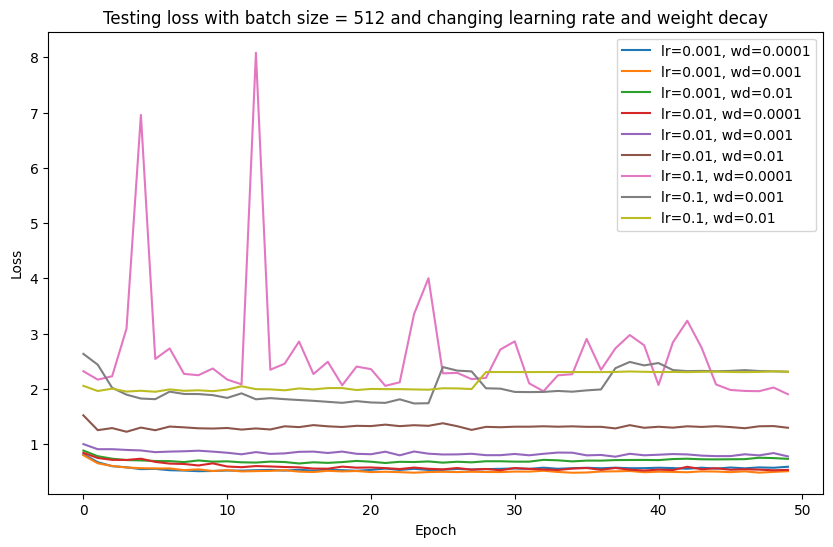

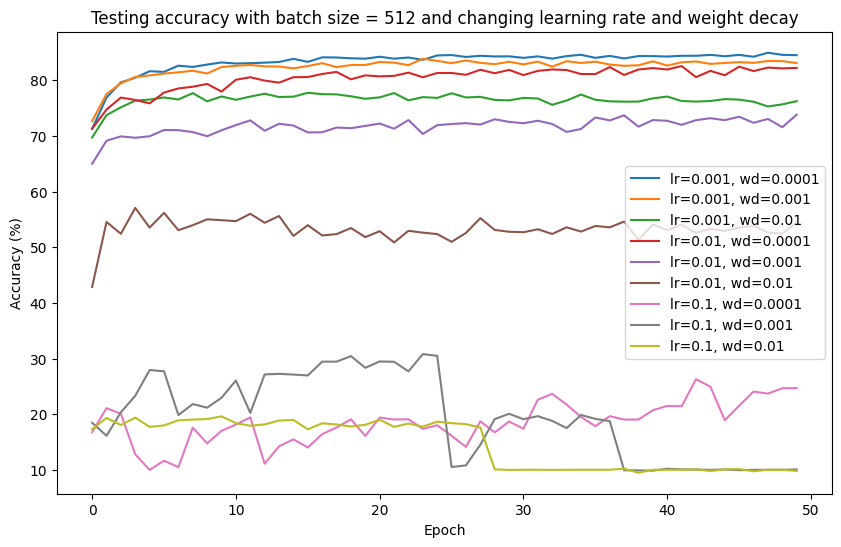

In [8]:
np_testing_accuracy_list_all_512 = np.array(testing_accuracy_list_all_512)
np.save("./testing_accuries_512.npy", np_testing_accuracy_list_all_512)
np_testing_loss_list_all_512 = np.array(testing_loss_list_all_512)
np.save("./testing_losses_512.npy", np_testing_loss_list_all_512)


np_training_accuracy_list_all_512 = np.array(training_accuracy_list_all_512)
np.save("./training_accuries_512.npy", np_training_accuracy_list_all_512)
np_training_loss_list_all_512 = np.array(training_loss_list_all_512)
np.save("./training_losses_512.npy", np_training_loss_list_all_512)

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all_512[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_512[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_512[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_512[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_512[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_512[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_512[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_512[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_512[8], label='lr=0.1, wd=0.01')

title = "Testing loss with batch size = 512 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all_512[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_512[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_512[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_512[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_512[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_512[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_512[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_512[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_512[8], label='lr=0.1, wd=0.01')

title = "Testing accuracy with batch size = 512 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)

Loaded pretrained weights for efficientnet-b0
1 average training loss: 1.278
Training Accuracy of the network on the 50000 train images: 55.586%
val_loss: 1.043887622654438
Accuracy of the network on the 10000 test images: 67.44%
2 average training loss: 0.927
Training Accuracy of the network on the 50000 train images: 69.158%
val_loss: 0.9338110908865929
Accuracy of the network on the 10000 test images: 69.91%
3 average training loss: 0.897
Training Accuracy of the network on the 50000 train images: 70.396%
val_loss: 0.900968924164772
Accuracy of the network on the 10000 test images: 70.99%
4 average training loss: 0.832
Training Accuracy of the network on the 50000 train images: 72.232%
val_loss: 0.8440883338451386
Accuracy of the network on the 10000 test images: 71.94%
5 average training loss: 0.787
Training Accuracy of the network on the 50000 train images: 73.774%
val_loss: 0.8737539023160934
Accuracy of the network on the 10000 test images: 72.3%
6 average training loss: 0.742
T

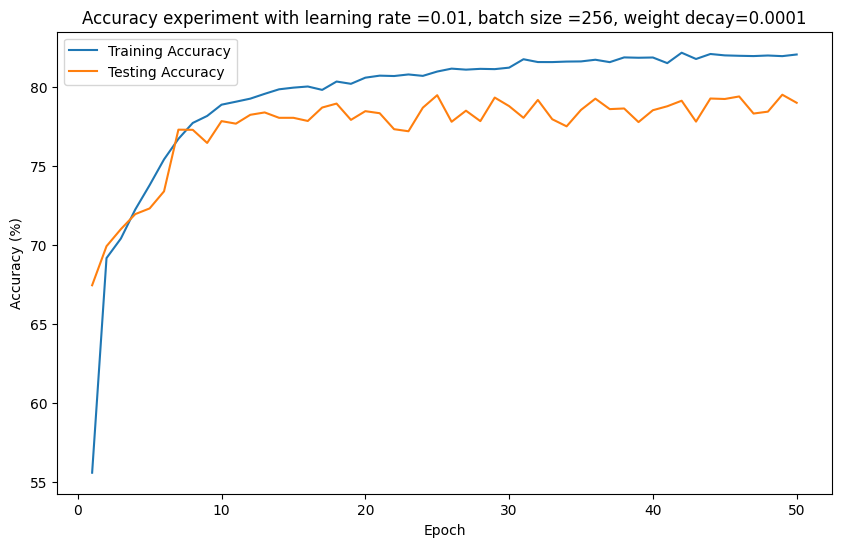

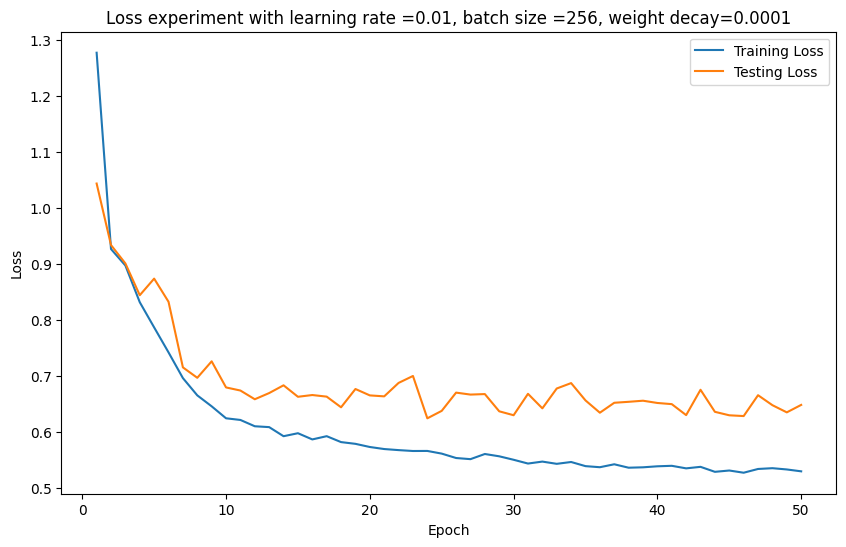

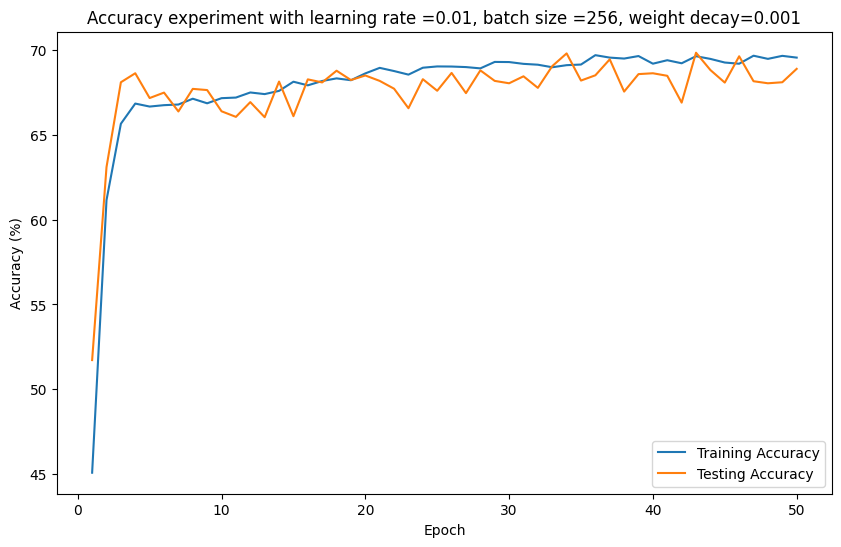

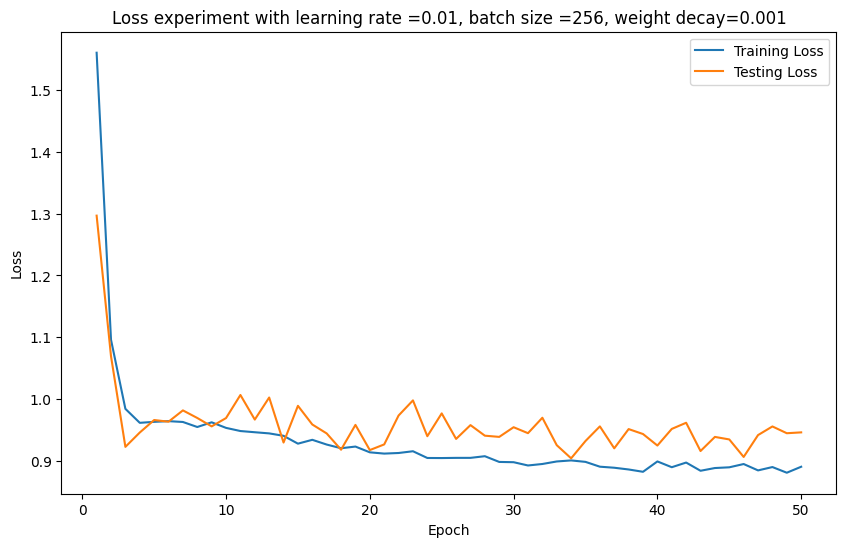

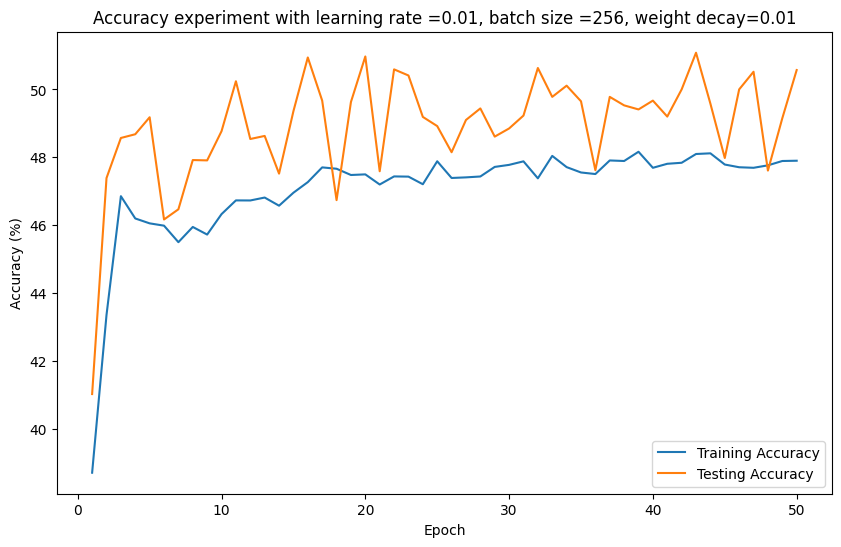

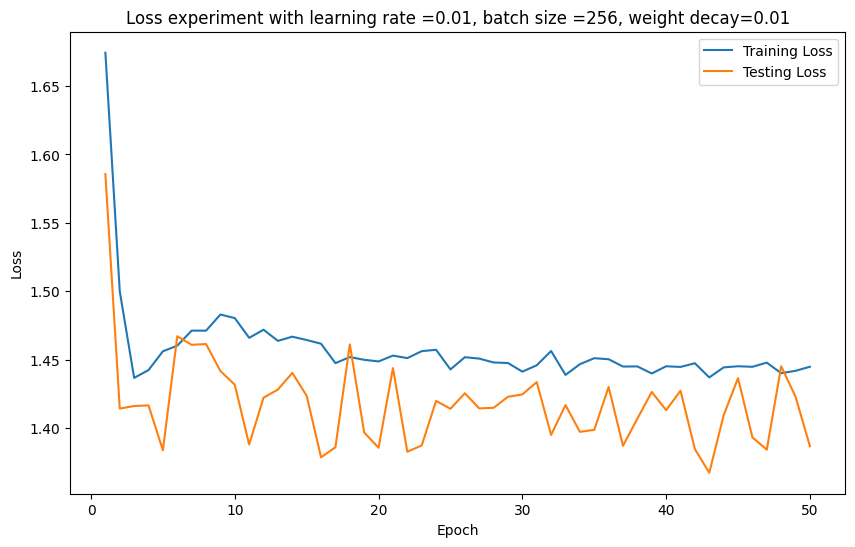

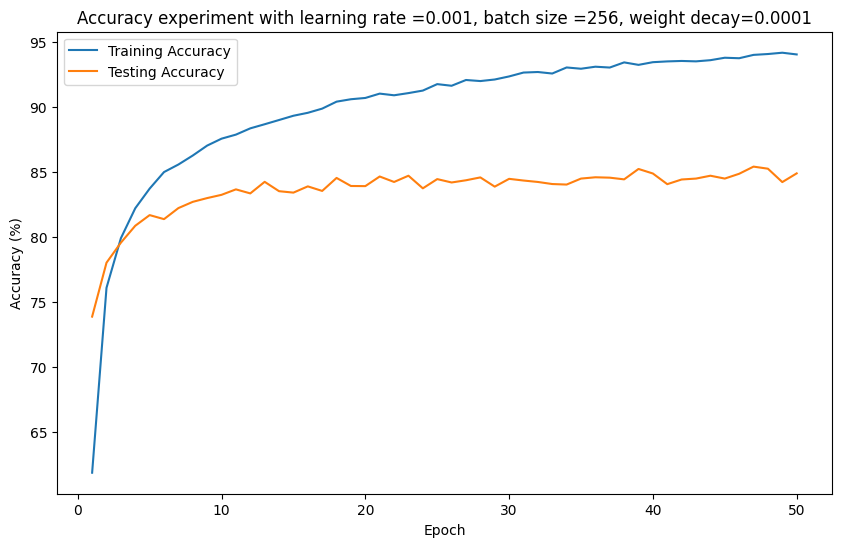

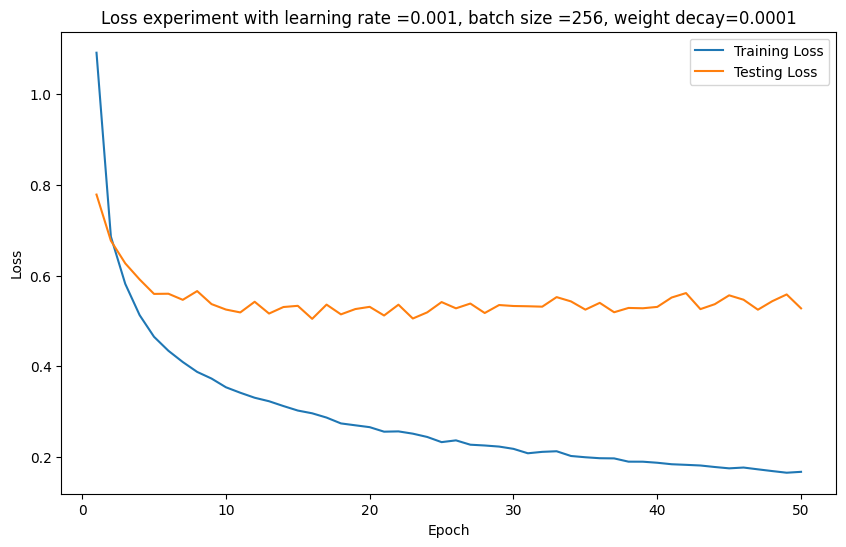

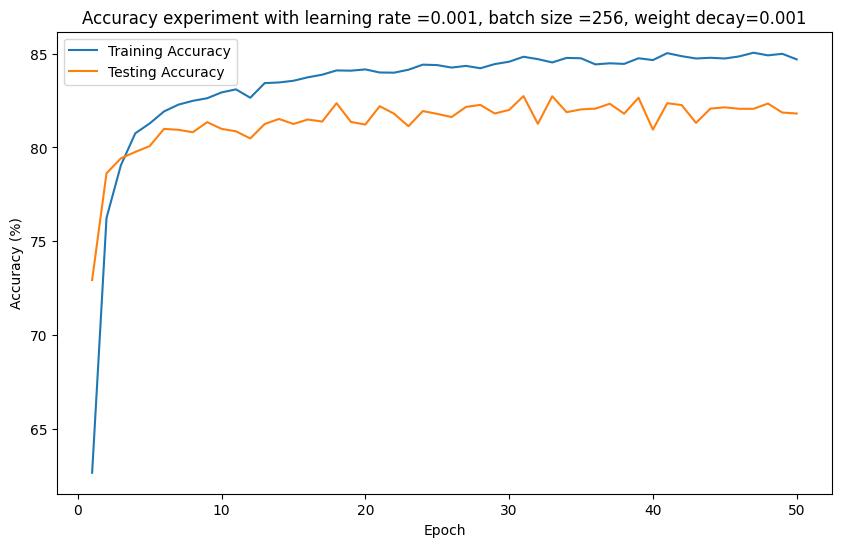

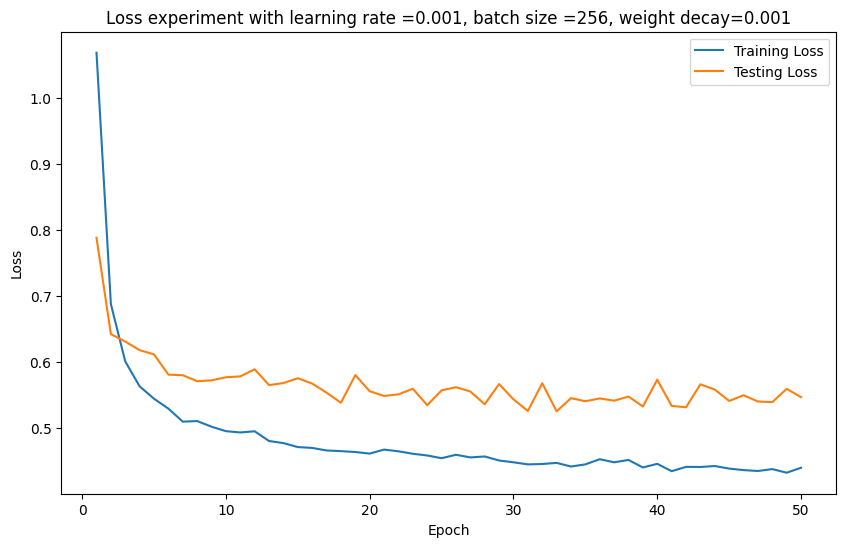

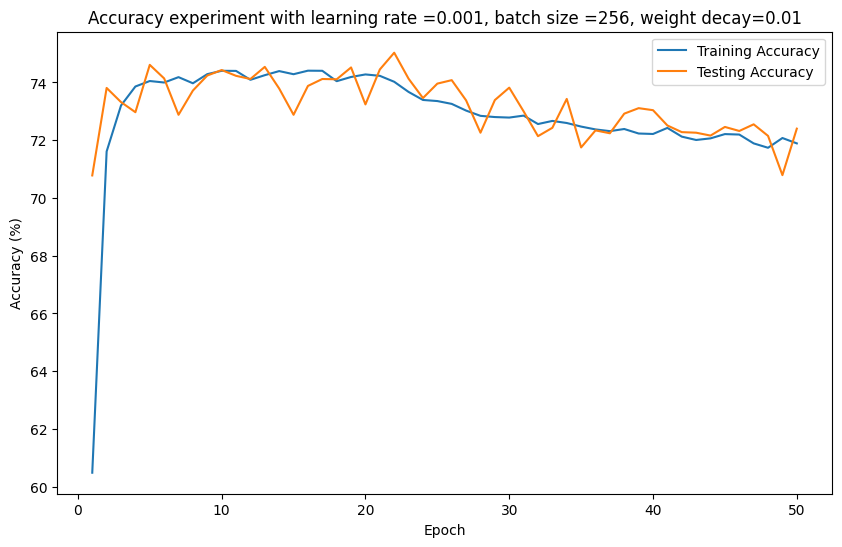

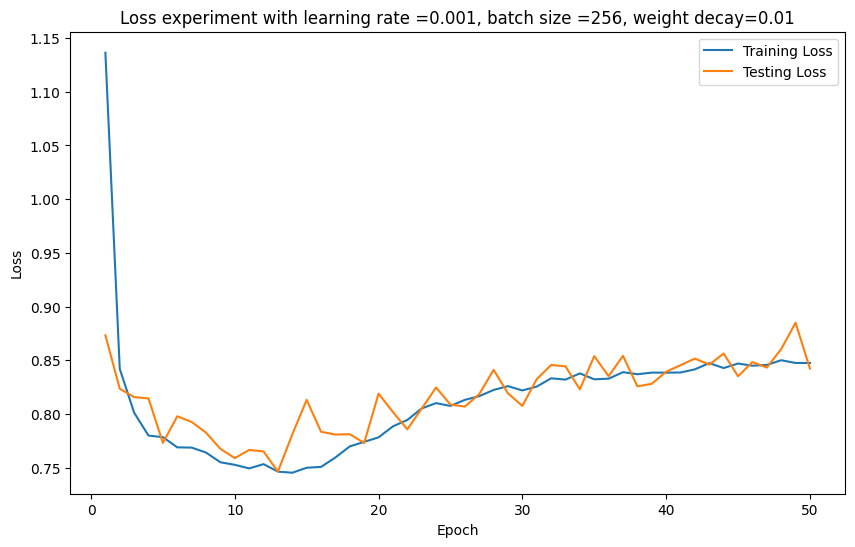

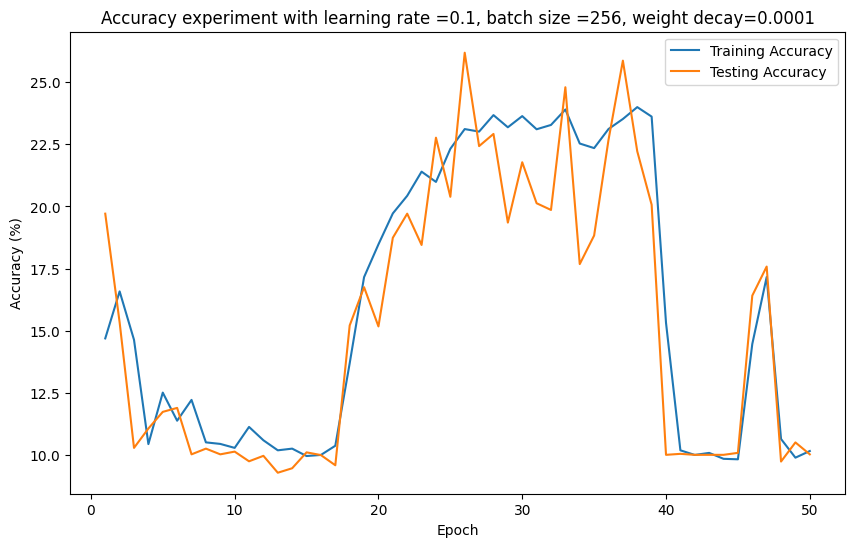

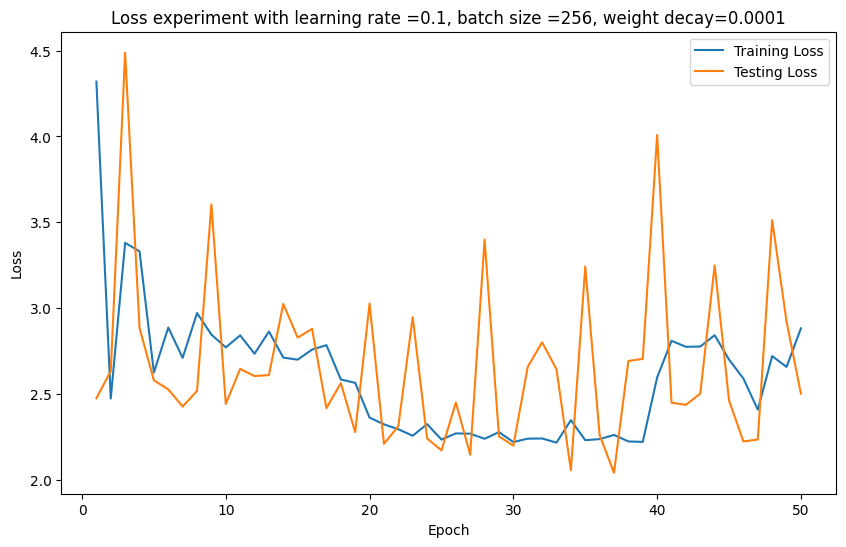

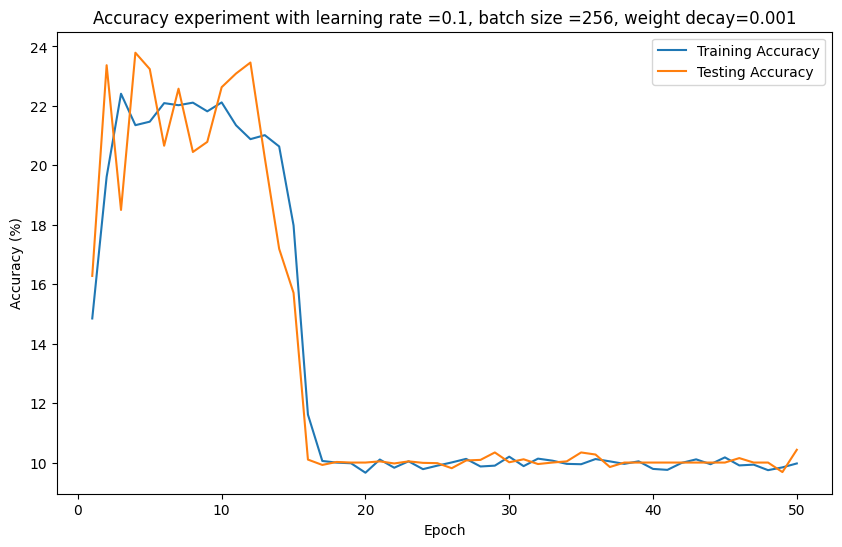

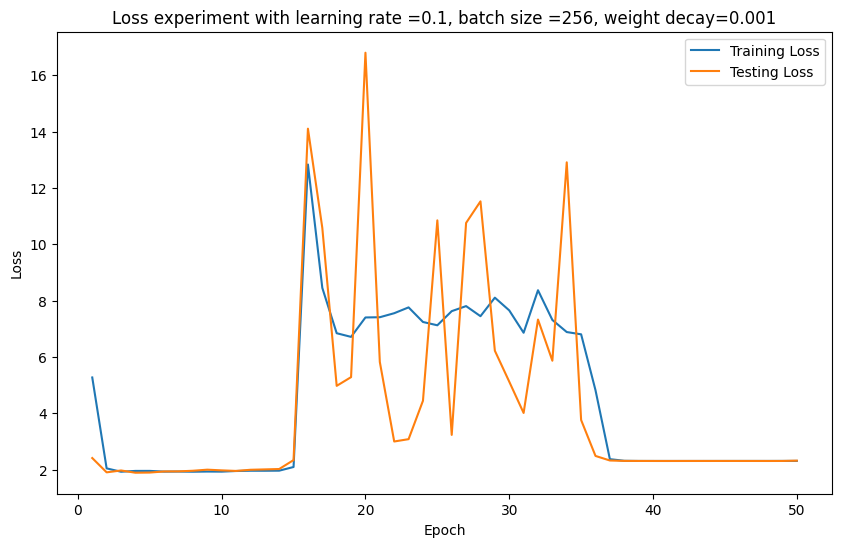

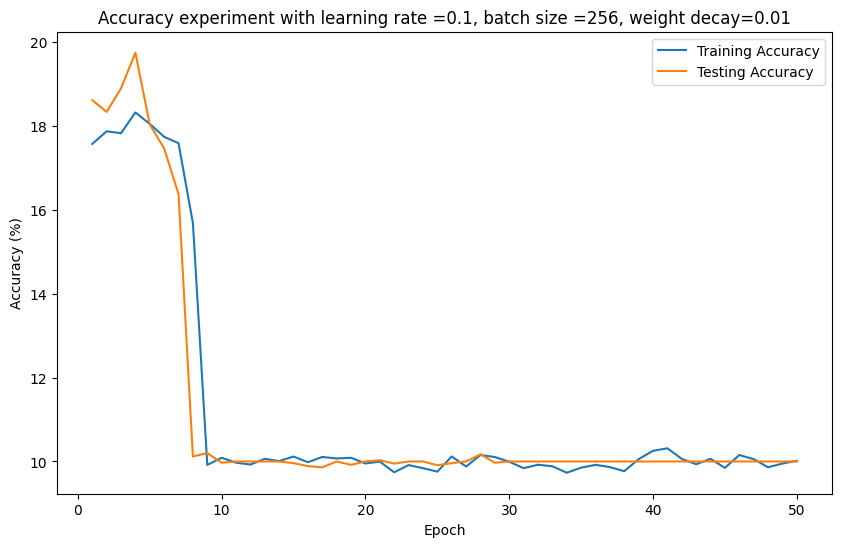

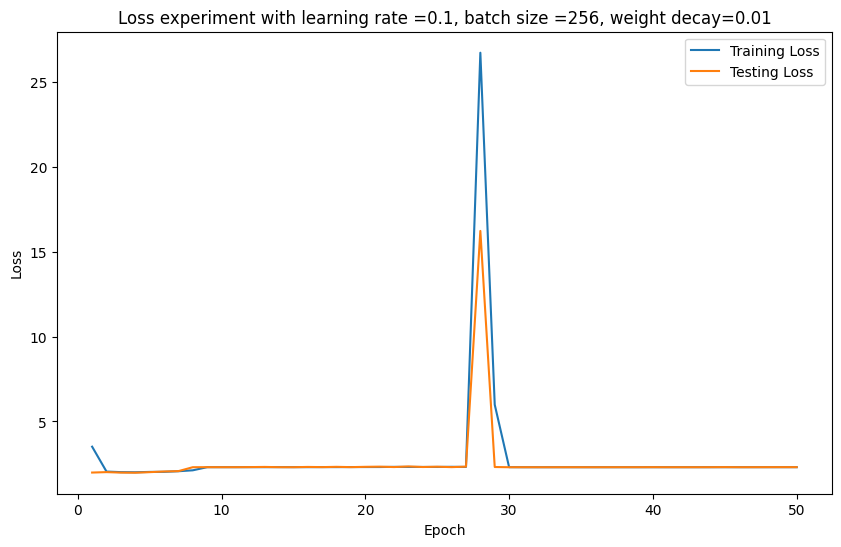

In [5]:
batch_s = 256
training_accuracy_list_all_256 = []
testing_accuracy_list_all_256 = []
training_loss_list_all_256 = []
testing_loss_list_all_256 = []
# Create data loaders
num_epochs = 50  # don't make it a variable first
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_s, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_s, shuffle=False, num_workers=8)
for learning_r in learning_rate:
    for weight_d in weight_decay:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10).to(device)
        optimiser = optim.Adam(model.parameters(), lr=learning_r, weight_decay = weight_d)
        title_1 = f"Accuracy experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        title_2 = f"Loss experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        epoch_list = []
        training_accuracy_list = []
        testing_accuracy_list = []
        training_loss_list = []
        testing_loss_list = []
        for epoch in range(num_epochs):
            training_loss = 0.0
            training_correct = 0
            training_total = 0
            num_batches_training = len(trainloader)
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                training_total += labels.size(0)
                training_correct += (predicted == labels).sum().item()
                training_loss += loss.item()
            average_training_loss = training_loss/num_batches_training
            print(f"{epoch + 1} average training loss: {average_training_loss:.3f}")
            print(f"Training Accuracy of the network on the 50000 train images: {100 * training_correct / training_total}%")
            epoch_list.append(epoch+1)
            training_accuracy_list.append(100 * training_correct / training_total)
            training_loss_list.append(average_training_loss)
            
            # Step 6: Evaluate the model
            with torch.no_grad():
                val_loss = 0
                number_batches = len(testloader)
                correct = 0
                total = 0
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    batch_loss = criterion(outputs, labels)
                    val_loss += batch_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                val_loss /= number_batches
                print("val_loss:", val_loss)
                print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
                testing_accuracy_list.append(100 * correct / total)
                testing_loss_list.append(val_loss)
        training_accuracy_list_all_256.append(training_accuracy_list)
        testing_accuracy_list_all_256.append(testing_accuracy_list)
        training_loss_list_all_256.append(training_loss_list)
        testing_loss_list_all_256.append(testing_loss_list)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_accuracy_list, label='Training Accuracy')
        plt.plot(epoch_list, testing_accuracy_list, label='Testing Accuracy')
        plt.title(title_1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.savefig(f"./new_results/{title_1}_cifar10.png", dpi=300)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_loss_list, label='Training Loss')
        plt.plot(epoch_list, testing_loss_list, label='Testing Loss')
        plt.title(title_2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"./new_results/{title_2}_cifar10.png", dpi=300)

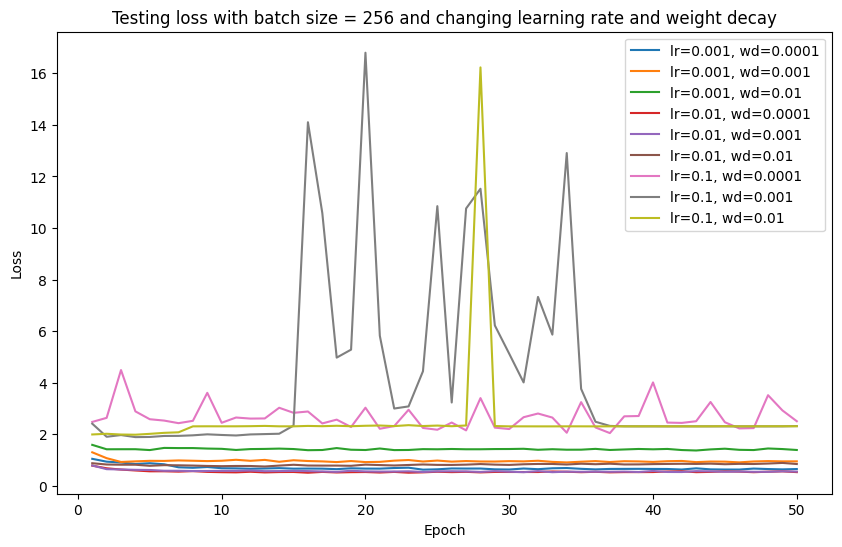

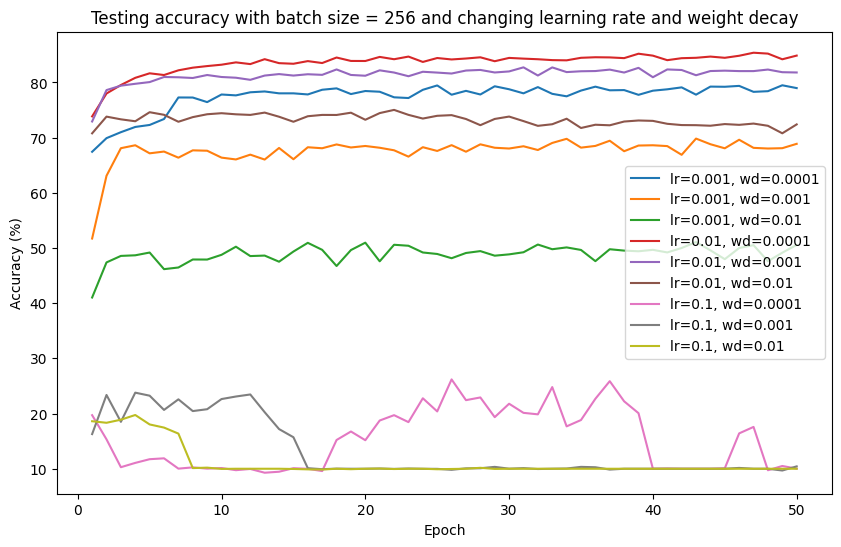

In [9]:
np_testing_accuracy_list_all_256 = np.array(testing_accuracy_list_all_256)
np.save("./new_results/testing_accuries_256.npy", np_testing_accuracy_list_all_256)
np_testing_loss_list_all_256 = np.array(testing_loss_list_all_256)
np.save("./new_results/testing_losses_256.npy", np_testing_loss_list_all_256)


np_training_accuracy_list_all_256 = np.array(training_accuracy_list_all_256)
np.save("./new_results/training_accuries_256.npy", np_training_accuracy_list_all_256)
np_training_loss_list_all_256 = np.array(training_loss_list_all_256)
np.save("./new_results/training_losses_256.npy", np_training_loss_list_all_256)

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all_256[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_256[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_256[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_256[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_256[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_256[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_256[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_256[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_256[8], label='lr=0.1, wd=0.01')

title = "Testing loss with batch size = 256 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./new_results/{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all_256[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_256[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_256[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_256[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_256[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_256[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_256[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_256[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_256[8], label='lr=0.1, wd=0.01')

title = "Testing accuracy with batch size = 256 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./new_results/{title}.png", dpi=300)

Loaded pretrained weights for efficientnet-b0
1 average training loss: 1.489
Training Accuracy of the network on the 50000 train images: 48.438%
val_loss: 1.264546868167346
Accuracy of the network on the 10000 test images: 56.46%
2 average training loss: 1.652
Training Accuracy of the network on the 50000 train images: 40.298%
val_loss: 1.9141748162764538
Accuracy of the network on the 10000 test images: 28.32%
3 average training loss: 1.725
Training Accuracy of the network on the 50000 train images: 35.552%
val_loss: 1.4192061922218226
Accuracy of the network on the 10000 test images: 47.03%
4 average training loss: 1.685
Training Accuracy of the network on the 50000 train images: 37.55%
val_loss: 1.577968491783625
Accuracy of the network on the 10000 test images: 39.67%
5 average training loss: 1.524
Training Accuracy of the network on the 50000 train images: 43.722%
val_loss: 1.4673176143742814
Accuracy of the network on the 10000 test images: 46.77%
6 average training loss: 1.283
T

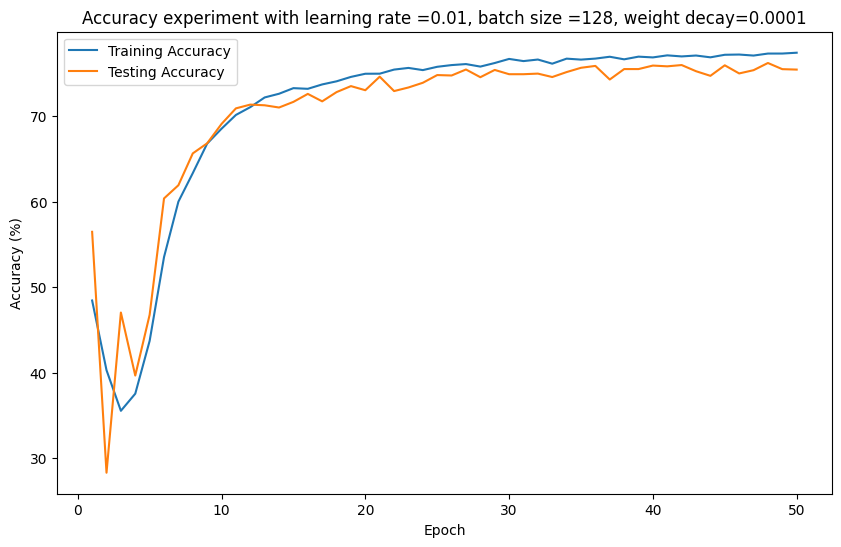

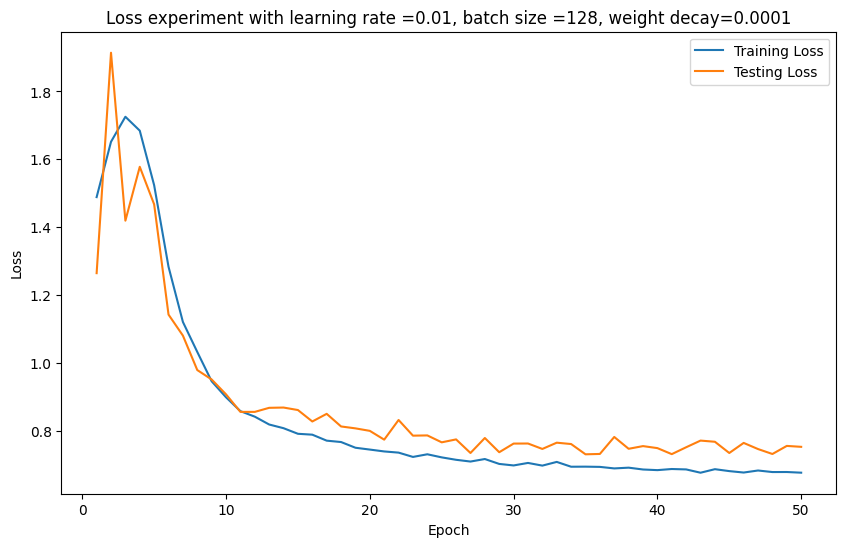

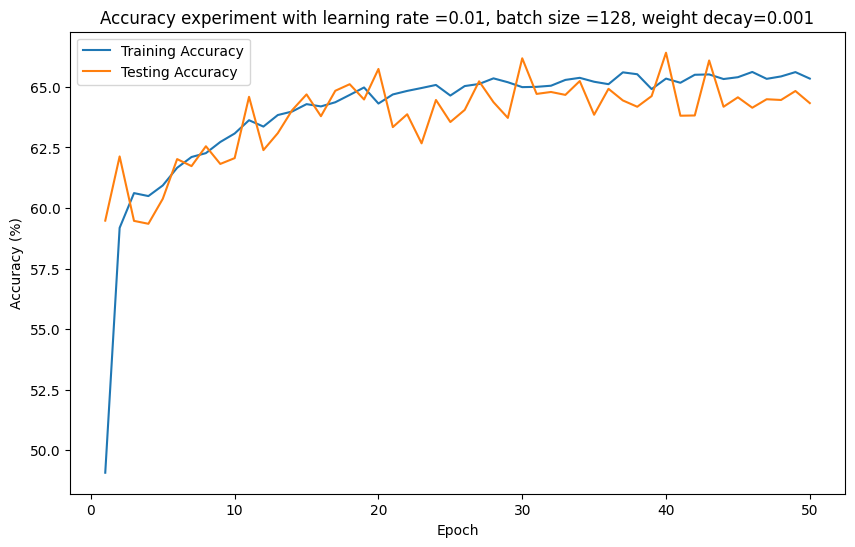

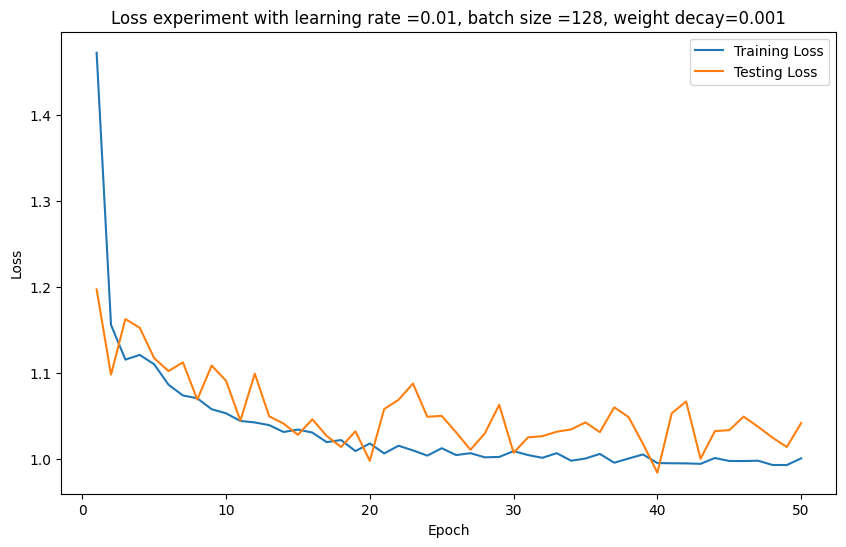

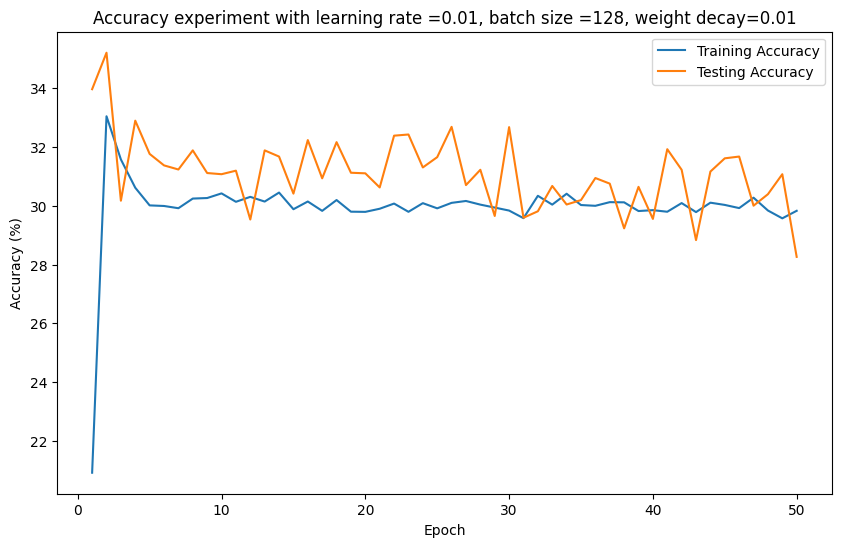

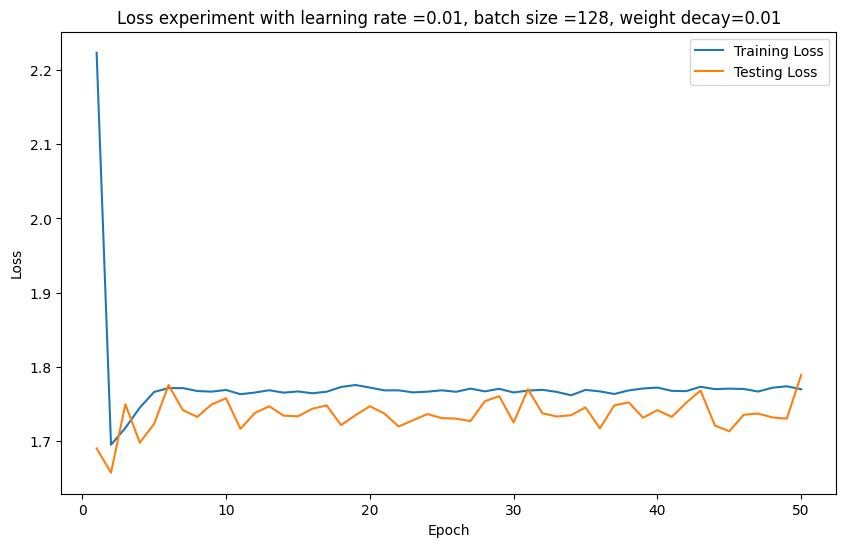

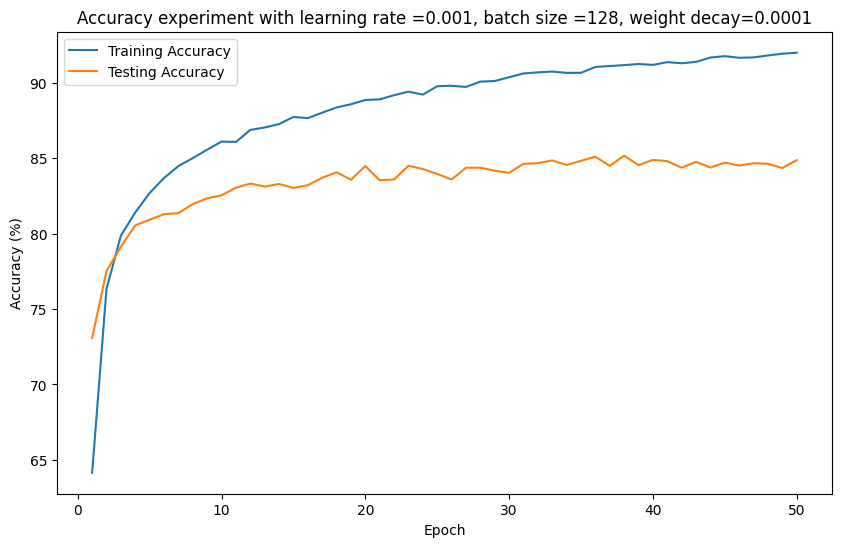

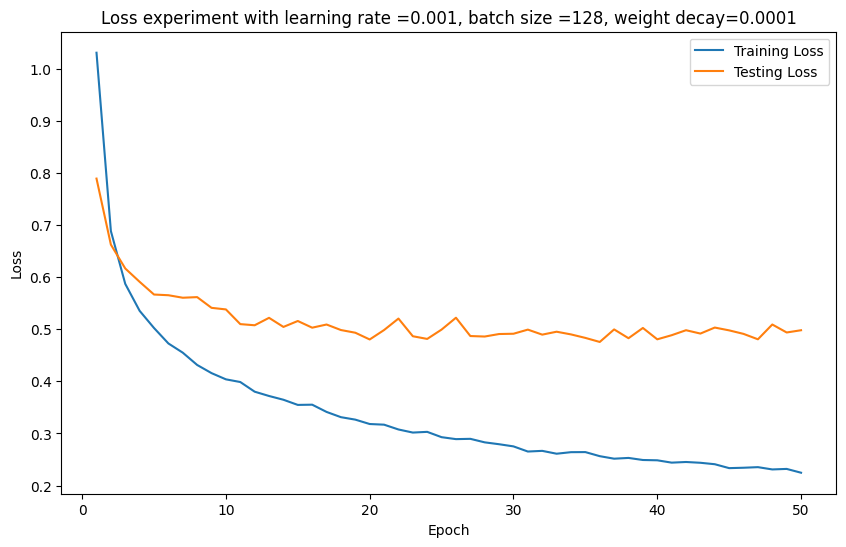

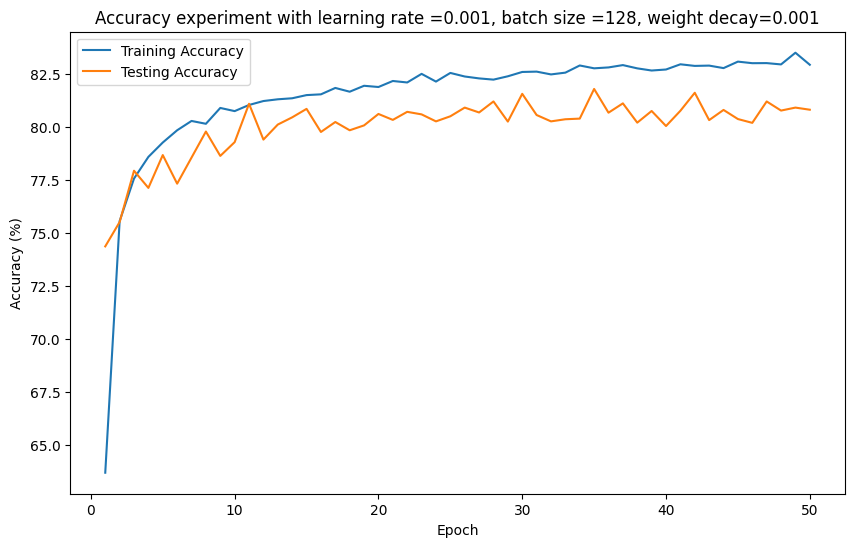

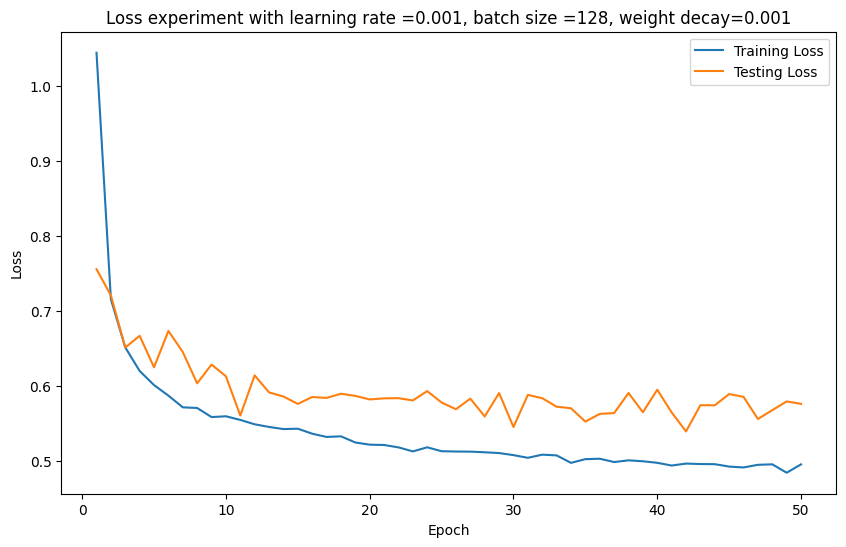

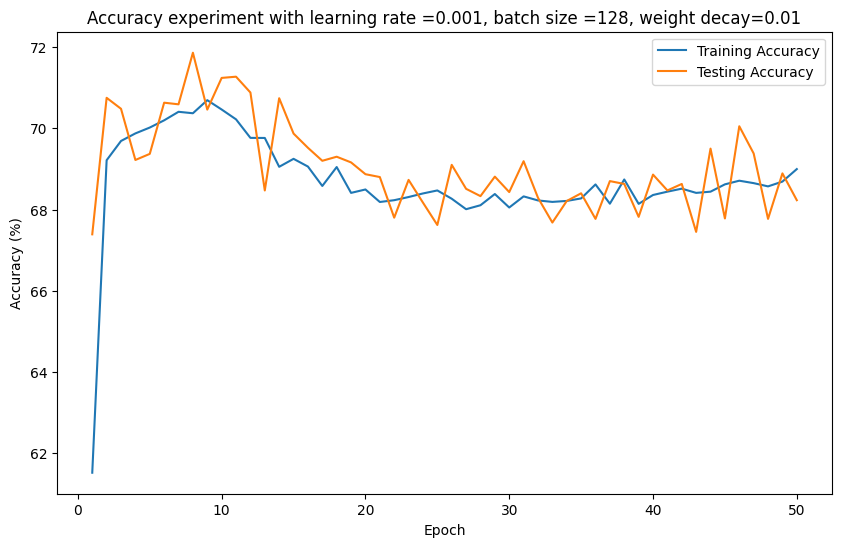

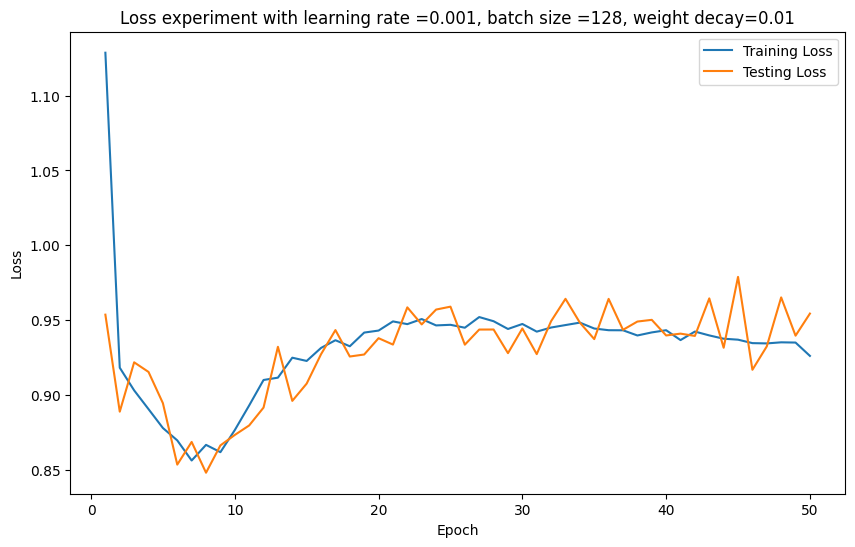

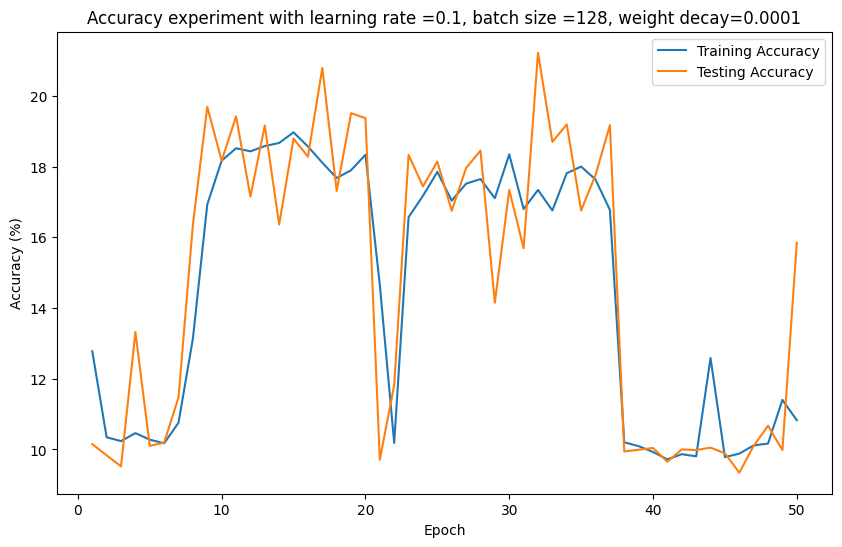

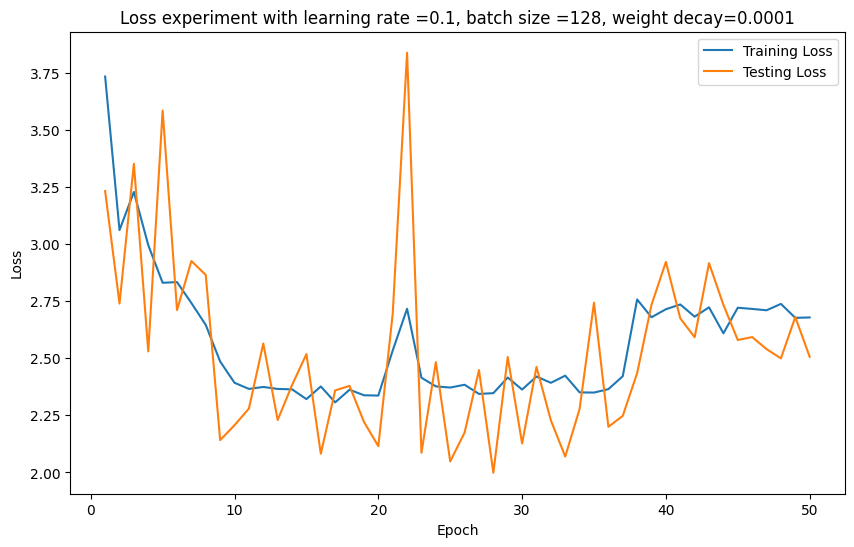

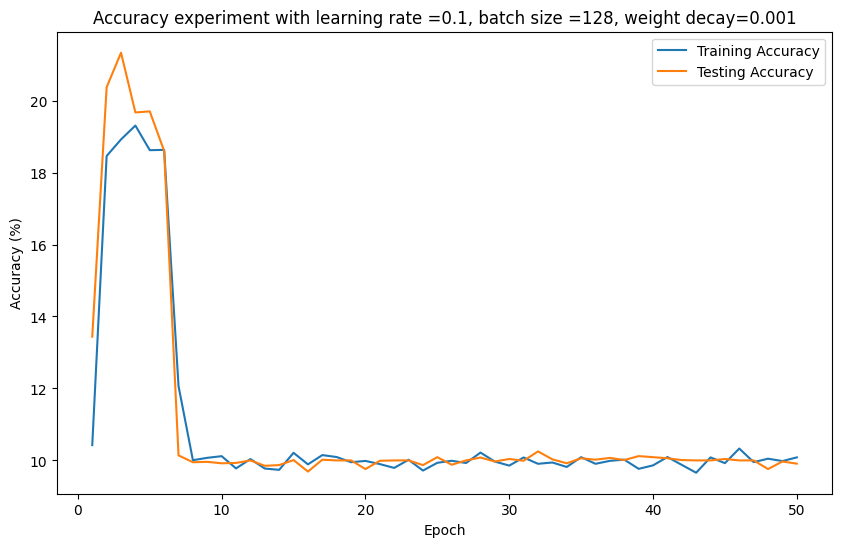

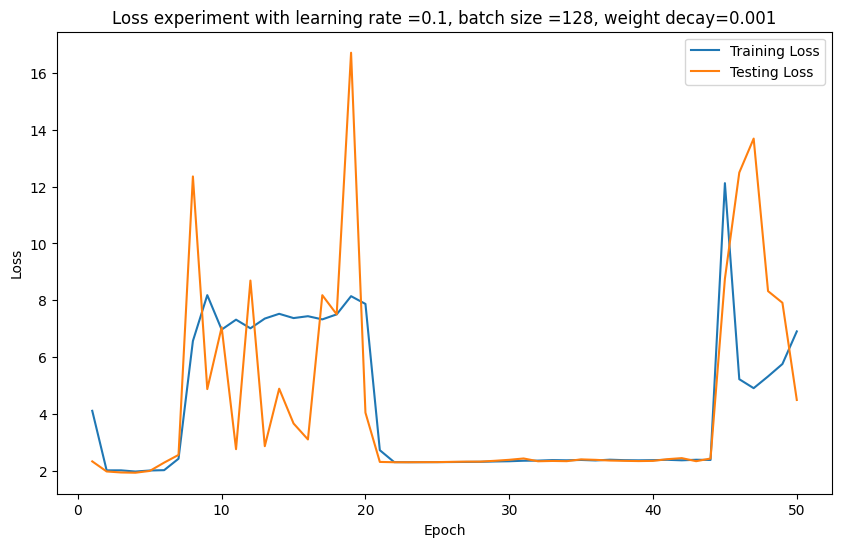

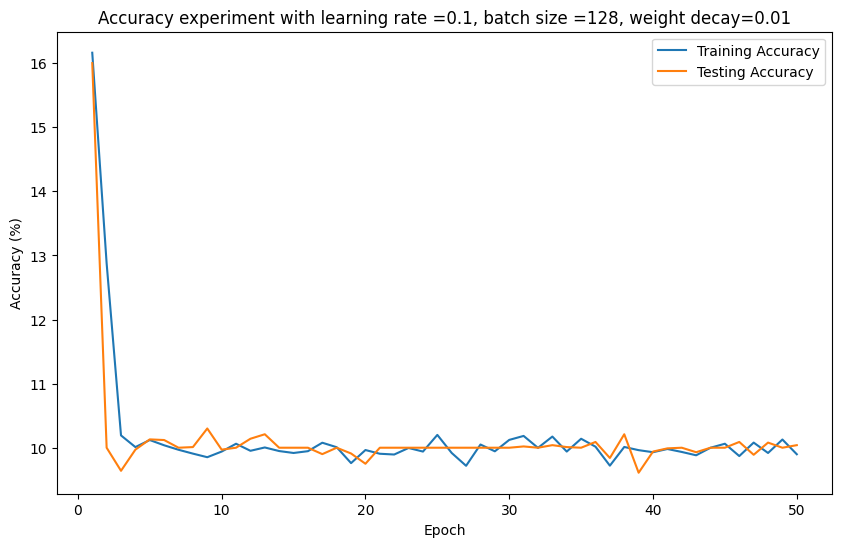

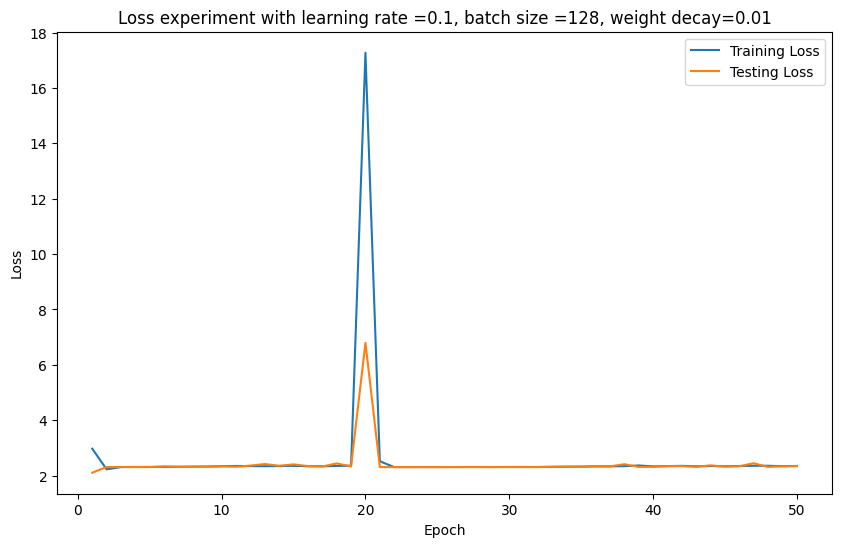

In [4]:
batch_s = 128
training_accuracy_list_all_128 = []
testing_accuracy_list_all_128 = []
training_loss_list_all_128 = []
testing_loss_list_all_128 = []
# Create data loaders
num_epochs = 50  # don't make it a variable first
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_s, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_s, shuffle=False, num_workers=8)
for learning_r in learning_rate:
    for weight_d in weight_decay:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10).to(device)
        optimiser = optim.Adam(model.parameters(), lr=learning_r, weight_decay = weight_d)
        title_1 = f"Accuracy experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        title_2 = f"Loss experiment with learning rate ={learning_r}, batch size ={batch_s}, weight decay={weight_d}"
        epoch_list = []
        training_accuracy_list = []
        testing_accuracy_list = []
        training_loss_list = []
        testing_loss_list = []
        for epoch in range(num_epochs):
            training_loss = 0.0
            training_correct = 0
            training_total = 0
            num_batches_training = len(trainloader)
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                training_total += labels.size(0)
                training_correct += (predicted == labels).sum().item()
                training_loss += loss.item()
            average_training_loss = training_loss/num_batches_training
            print(f"{epoch + 1} average training loss: {average_training_loss:.3f}")
            print(f"Training Accuracy of the network on the 50000 train images: {100 * training_correct / training_total}%")
            epoch_list.append(epoch+1)
            training_accuracy_list.append(100 * training_correct / training_total)
            training_loss_list.append(average_training_loss)
            
            # Step 6: Evaluate the model
            with torch.no_grad():
                val_loss = 0
                number_batches = len(testloader)
                correct = 0
                total = 0
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    batch_loss = criterion(outputs, labels)
                    val_loss += batch_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                val_loss /= number_batches
                print("val_loss:", val_loss)
                # Reduce learning rate when validation loss plateaus
                # scheduler.step(val_loss)
                print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
                testing_accuracy_list.append(100 * correct / total)
                testing_loss_list.append(val_loss)
        training_accuracy_list_all_128.append(training_accuracy_list)
        testing_accuracy_list_all_128.append(testing_accuracy_list)
        training_loss_list_all_128.append(training_loss_list)
        testing_loss_list_all_128.append(testing_loss_list)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_accuracy_list, label='Training Accuracy')
        plt.plot(epoch_list, testing_accuracy_list, label='Testing Accuracy')
        plt.title(title_1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.savefig(f"./128/{title_1}_cifar10.png", dpi=300)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, training_loss_list, label='Training Loss')
        plt.plot(epoch_list, testing_loss_list, label='Testing Loss')
        plt.title(title_2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"./128/{title_2}_cifar10.png", dpi=300)

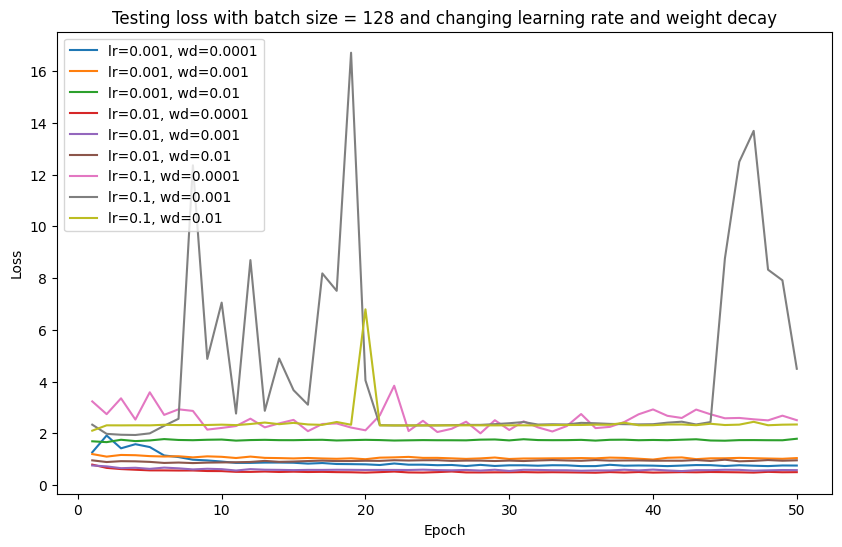

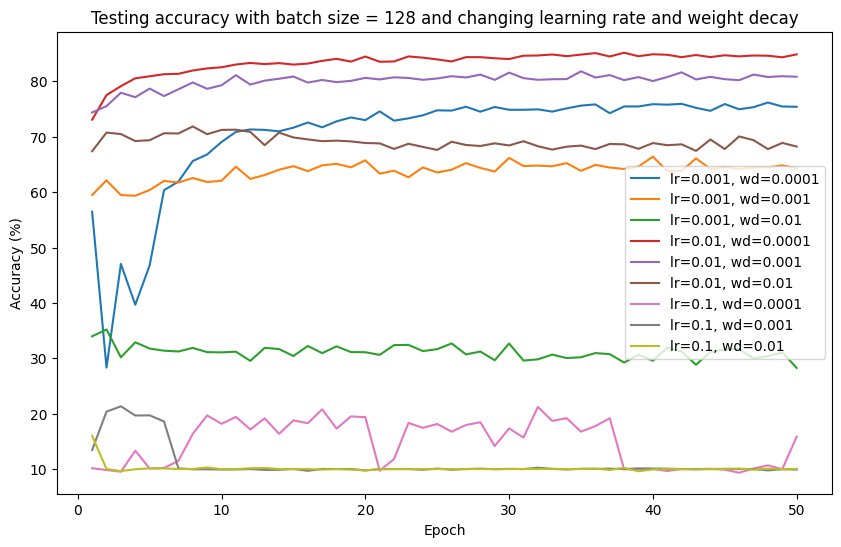

In [5]:
np_testing_accuracy_list_all_128 = np.array(testing_accuracy_list_all_128)
np.save("./128/testing_accuries_128.npy", np_testing_accuracy_list_all_128)
np_testing_loss_list_all_128 = np.array(testing_loss_list_all_128)
np.save("./new_results/testing_losses_128.npy", np_testing_loss_list_all_128)


np_training_accuracy_list_all_128 = np.array(training_accuracy_list_all_128)
np.save("./new_results/training_accuries_128.npy", np_training_accuracy_list_all_128)
np_training_loss_list_all_128 = np.array(training_loss_list_all_128)
np.save("./new_results/training_losses_128.npy", np_training_loss_list_all_128)

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_loss_list_all_128[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_128[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_128[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_128[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_128[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_128[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_128[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_128[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_128[8], label='lr=0.1, wd=0.01')

title = "Testing loss with batch size = 128 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./128/{title}.png", dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(epoch_list, testing_accuracy_list_all_128[0], label='lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_128[1], label='lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_128[2], label='lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_128[3], label='lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_128[4], label='lr=0.01, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_128[5], label='lr=0.01, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_128[6], label='lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_128[7], label='lr=0.1, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_128[8], label='lr=0.1, wd=0.01')

title = "Testing accuracy with batch size = 128 and changing learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./128/{title}.png", dpi=300)

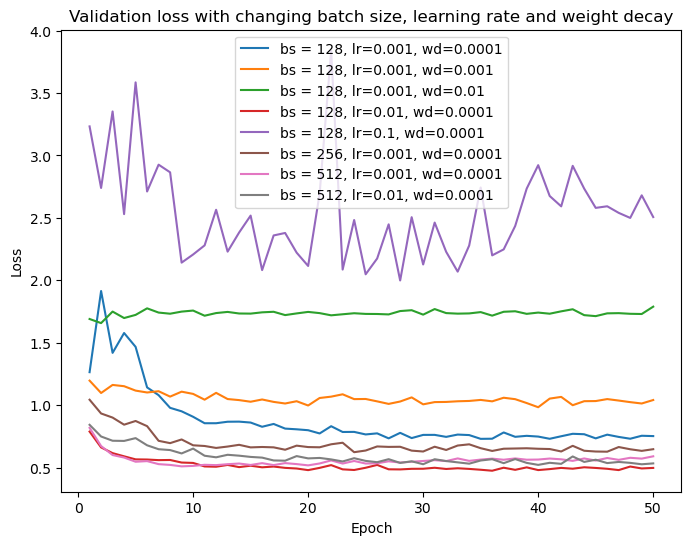

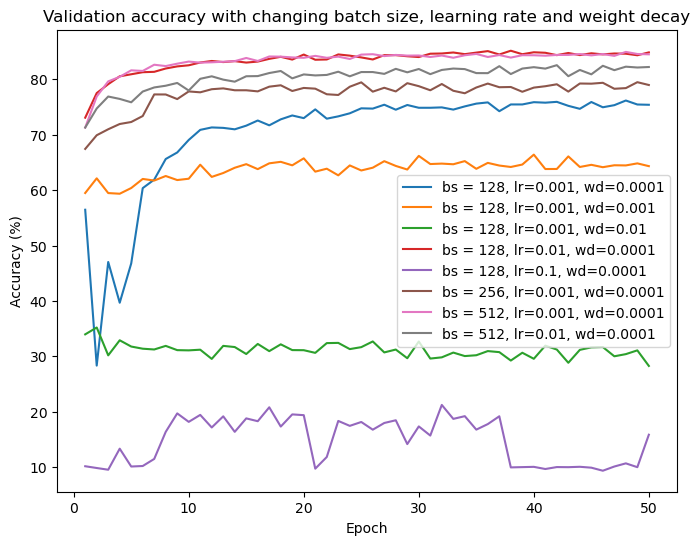

In [2]:
import numpy as np
import matplotlib.pyplot as plt

epoch_list = np.arange(1, 51, 1)
testing_loss_list_all_128 = np.load("./testing_losses_128.npy")
testing_accuracy_list_all_128 = np.load("./testing_accuries_128.npy")
testing_loss_list_all_256 = np.load("./testing_losses_256.npy")
testing_accuracy_list_all_256 = np.load("./testing_accuries_256.npy")
testing_accuracy_list_all_512 = np.load("./testing_accuries_512.npy")
testing_loss_list_all_512 = np.load("./testing_losses_512.npy")
testing_accuracy_list_all_1024 = np.load("./testing_accuries(1024).npy")
testing_loss_list_all_1024 = np.load("./testing_losses(1024).npy")

plt.figure(figsize=(8,6))
plt.plot(epoch_list, testing_loss_list_all_128[0], label='bs = 128, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_128[1], label='bs = 128, lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_loss_list_all_128[2], label='bs = 128, lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_loss_list_all_128[3], label='bs = 128, lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_128[6], label='bs = 128, lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_256[0], label='bs = 256, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_512[0], label='bs = 512, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_loss_list_all_512[3], label='bs = 512, lr=0.01, wd=0.0001')

title = "Validation loss with changing batch size, learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)


plt.figure(figsize=(8,6))
plt.plot(epoch_list, testing_accuracy_list_all_128[0], label='bs = 128, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_128[1], label='bs = 128, lr=0.001, wd=0.001')
plt.plot(epoch_list, testing_accuracy_list_all_128[2], label='bs = 128, lr=0.001, wd=0.01')
plt.plot(epoch_list, testing_accuracy_list_all_128[3], label='bs = 128, lr=0.01, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_128[6], label='bs = 128, lr=0.1, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_256[0], label='bs = 256, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_512[0], label='bs = 512, lr=0.001, wd=0.0001')
plt.plot(epoch_list, testing_accuracy_list_all_512[3], label='bs = 512, lr=0.01, wd=0.0001')

title = "Validation accuracy with changing batch size, learning rate and weight decay"
plt.title(title)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"./{title}.png", dpi=300)